
PhIP-seq Plate Effect Correction and Normalization Pipeline

This notebook performs comprehensive plate effect correction for PhIP-seq data
using control samples and provides extensive quality control visualizations.
Optimized for speed using vectorized operations.

Author: Analysis Pipeline

Date: 2025-11-07



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# https://mokole.com/palette.html
twelve_custom_colors = [
        "#2f4f4f",
        "#228b22",
        "#7f0000",
        "#00008b",
        "#ff8c00",
        "#ffff00",
        "#00ff00",
        "#00ffff",
        "#ff00ff",
        "#1e90ff",
        "#eee8aa",
        "#ff69b4"
]

In [3]:
%%time

print("=" * 80)
print("STEP 1: Loading Data")
print("=" * 80)

# Load the data matrix (peptide counts)
# Expected format: First column is sample ID, remaining columns are peptide IDs
data_matrix = pd.read_csv('data.csv', index_col=0)
print(f"Data matrix shape: {data_matrix.shape}")
print(f"Samples: {data_matrix.shape[0]}, Peptides: {data_matrix.shape[1]}")

# Load the manifest (sample metadata)
manifest = pd.read_csv('manifest.csv')
print(f"\nManifest shape: {manifest.shape}")
print(f"Columns: {list(manifest.columns)}")

# Ensure sample IDs match between files
manifest = manifest.set_index('sample')
common_samples = data_matrix.index.intersection(manifest.index)
print(f"\nCommon samples between files: {len(common_samples)}")

# Align data
data_matrix = data_matrix.loc[common_samples]
manifest = manifest.loc[common_samples]


STEP 1: Loading Data
Data matrix shape: (1149, 115292)
Samples: 1149, Peptides: 115292

Manifest shape: (1149, 8)
Columns: ['sample', 'subject', 'type', 'study', 'group', 'age', 'sex', 'plate']

Common samples between files: 1149
CPU times: user 1min 16s, sys: 2.87 s, total: 1min 19s
Wall time: 1min 19s


In [4]:
%%time

print("\n" + "=" * 80)
print("STEP 2: Classifying Sample Types")
print("=" * 80)

# Classify samples based on their IDs using vectorized operations
# CSE = Commercial Serum (positive control)
# Blank = No-serum control (negative control, background)
# PLib = Phage Library (input control)
# Others = Experimental samples

sample_ids_upper = manifest.index.str.upper()
manifest['sample_type'] = 'Experimental'  # Default
manifest.loc[sample_ids_upper.str.startswith('CSE'), 'sample_type'] = 'Commercial_Serum'
manifest.loc[sample_ids_upper.str.startswith('BLANK'), 'sample_type'] = 'No_Serum'
manifest.loc[sample_ids_upper.str.startswith('PLIB'), 'sample_type'] = 'Phage_Library'

# Print sample type distribution
print("\nSample type distribution:")
print(manifest['sample_type'].value_counts())
print("\nSamples per plate:")
print(manifest.groupby(['plate', 'sample_type']).size().unstack(fill_value=0))



STEP 2: Classifying Sample Types

Sample type distribution:
sample_type
Experimental        1008
No_Serum              93
Commercial_Serum      24
Phage_Library         24
Name: count, dtype: int64

Samples per plate:
sample_type  Commercial_Serum  Experimental  No_Serum  Phage_Library
plate                                                               
1                           2            84         7              2
2                           2            84         8              2
3                           2            84         8              2
4                           2            84         8              2
5                           2            84         8              2
6                           2            84         7              2
13                          2            84         7              2
14                          2            84         8              2
15                          2            84         8              2
16                    

In [5]:
%%time

print("\n" + "=" * 80)
print("STEP 3: Raw Data Quality Assessment")
print("=" * 80)

# Calculate basic statistics per sample using vectorized operations
# Total counts indicate overall signal strength
# Non-zero peptides indicate library coverage
stats_df = pd.DataFrame({
    'total_counts': data_matrix.sum(axis=1),
    'non_zero_peptides': (data_matrix > 0).sum(axis=1),
    'mean_signal': data_matrix.mean(axis=1),
    'median_signal': data_matrix.median(axis=1),
    'max_signal': data_matrix.max(axis=1)
})
stats_df = pd.concat([stats_df, manifest], axis=1)

print("\nBasic statistics by sample type:")
print(stats_df.groupby('sample_type')['total_counts'].describe())

# Calculate coefficient of variation across plates
# High CV indicates significant plate effects
plate_cv = stats_df.groupby('sample_type')['total_counts'].agg(['mean', 'std'])
plate_cv['cv'] = plate_cv['std'] / plate_cv['mean']
print("\nCoefficient of Variation by Sample Type (higher = more plate effect):")
print(plate_cv)



STEP 3: Raw Data Quality Assessment

Basic statistics by sample type:
                   count          mean           std       min         25%  \
sample_type                                                                  
Commercial_Serum    24.0  2.123970e+06  8.598276e+05  229696.0  1726799.25   
Experimental      1008.0  2.232475e+06  1.001532e+06     148.0  1754245.00   
No_Serum            93.0  2.094677e+06  9.979723e+05  194557.0  1600529.00   
Phage_Library       24.0  1.712797e+06  9.467603e+05  169034.0  1315530.00   

                        50%         75%        max  
sample_type                                         
Commercial_Serum  2052388.0  2317879.25  4162180.0  
Experimental      2077009.5  2731108.25  5265171.0  
No_Serum          1916026.0  2424801.00  4791563.0  
Phage_Library     1632678.0  1873019.75  3953202.0  

Coefficient of Variation by Sample Type (higher = more plate effect):
                          mean           std        cv
sample_type     

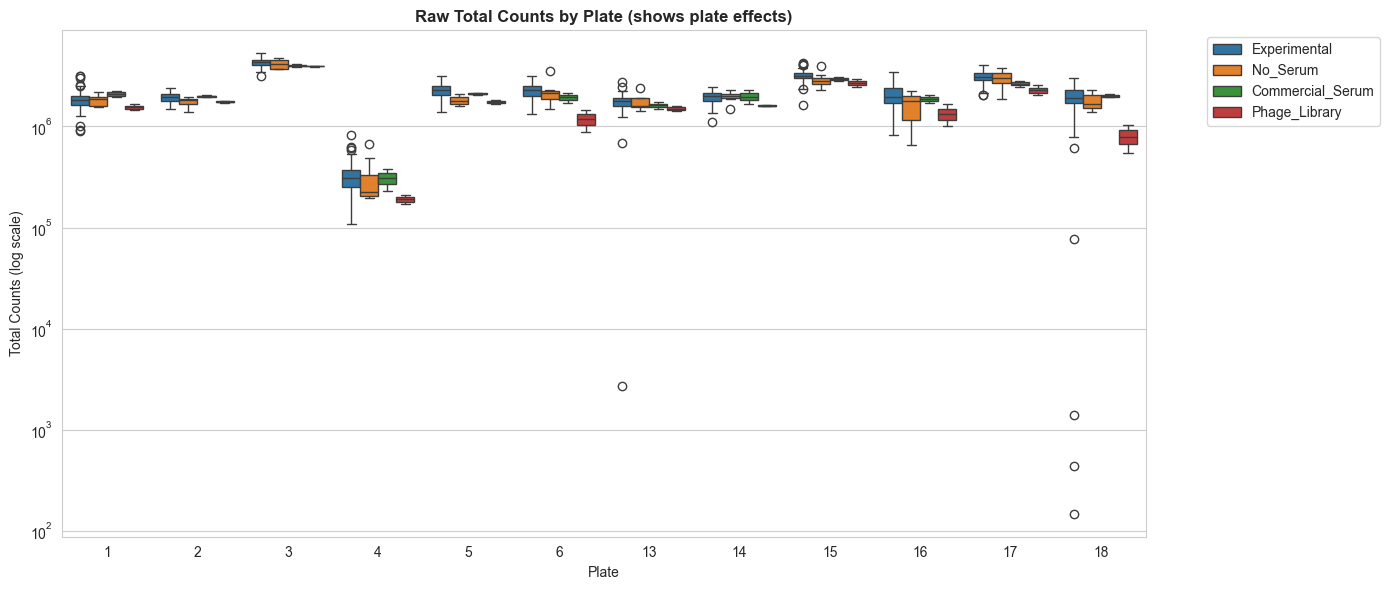

In [6]:
# Visualization 1: Total counts by plate
plt.figure(figsize=(14, 6))
sns.boxplot(data=stats_df, x='plate', y='total_counts', hue='sample_type')
plt.title('Raw Total Counts by Plate (shows plate effects)', fontsize=12, fontweight='bold')
plt.xlabel('Plate')
plt.ylabel('Total Counts (log scale)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


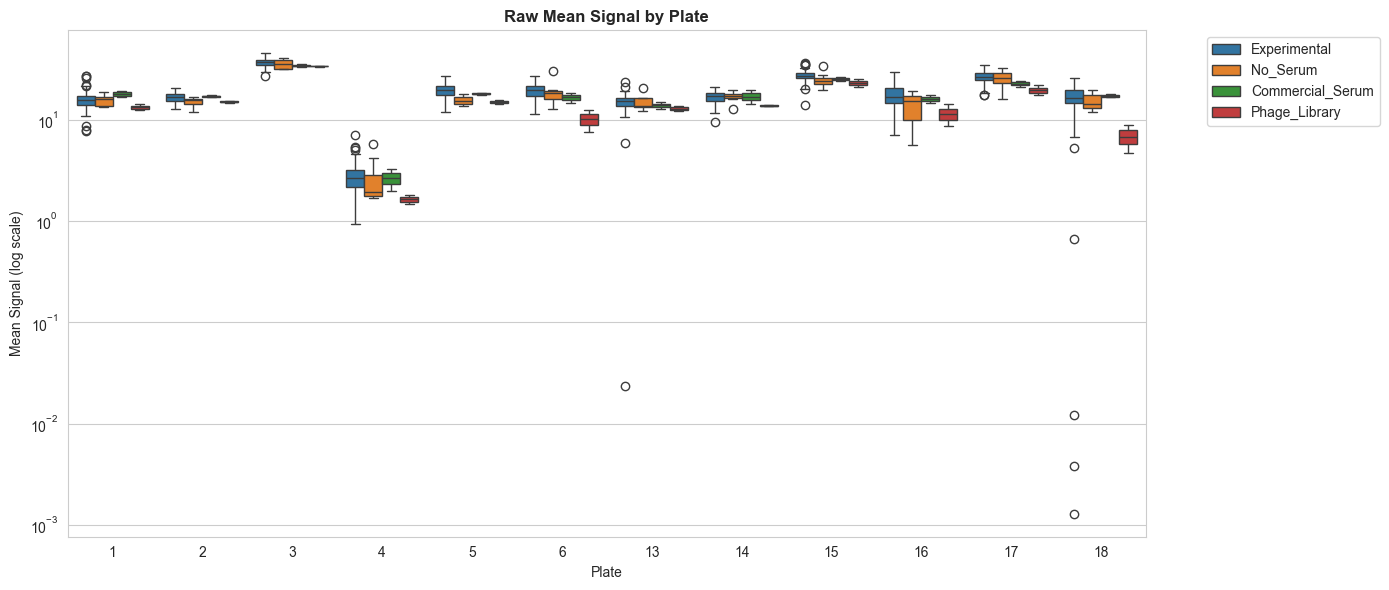

In [7]:
# Visualization 2: Mean signal by plate
plt.figure(figsize=(14, 6))
sns.boxplot(data=stats_df, x='plate', y='mean_signal', hue='sample_type')
plt.title('Raw Mean Signal by Plate', fontsize=12, fontweight='bold')
plt.xlabel('Plate')
plt.ylabel('Mean Signal (log scale)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


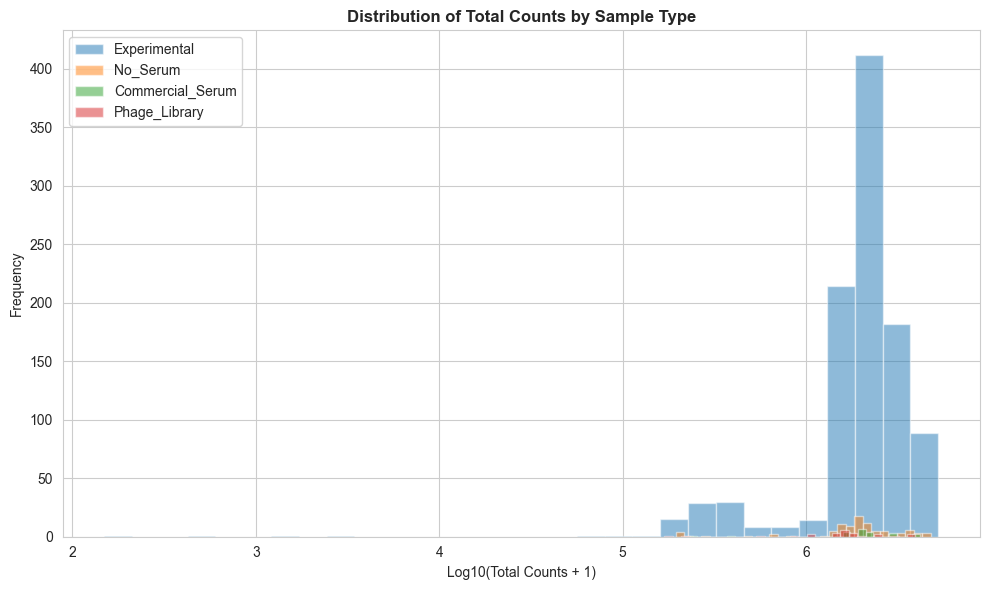

In [8]:
# Visualization 3: Distribution by sample type
plt.figure(figsize=(10, 6))
for sample_type in stats_df['sample_type'].unique():
    subset = stats_df[stats_df['sample_type'] == sample_type]['total_counts']
    plt.hist(np.log10(subset + 1), alpha=0.5, label=sample_type, bins=30)
plt.title('Distribution of Total Counts by Sample Type', fontsize=12, fontweight='bold')
plt.xlabel('Log10(Total Counts + 1)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


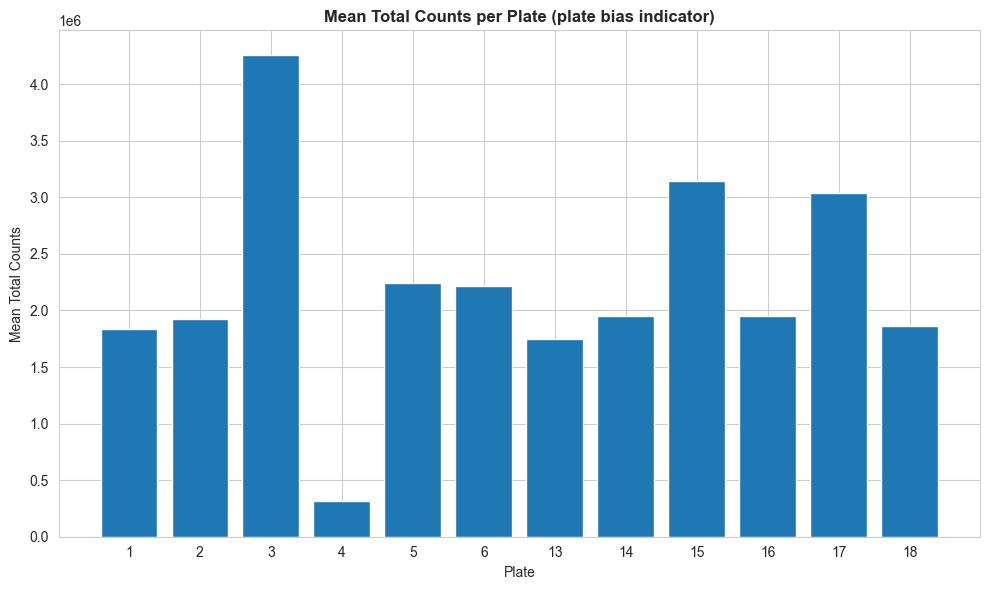

In [9]:
# Visualization 4: Plate effect
plt.figure(figsize=(10, 6))
plate_means = stats_df.groupby('plate')['total_counts'].mean()
plt.bar(range(len(plate_means)), plate_means.values)
plt.title('Mean Total Counts per Plate (plate bias indicator)', fontsize=12, fontweight='bold')
plt.xlabel('Plate')
plt.ylabel('Mean Total Counts')
plt.xticks(range(len(plate_means)), plate_means.index)
plt.tight_layout()
plt.show()


In [10]:
%%time

print("\n" + "=" * 80)
print("STEP 4: PCA on Raw Data (before normalization)")
print("=" * 80)

# Log-transform data for PCA
# Log transformation reduces the impact of extreme values and normalizes distributions
data_log = np.log10(data_matrix + 1)

# Perform PCA
# PCA helps visualize overall data structure and identify batch effects
pca = PCA(n_components=10)
pca_result = pca.fit_transform(data_log)
pca_df = pd.DataFrame(pca_result[:, :5], 
                       columns=[f'PC{i+1}' for i in range(5)],
                       index=data_matrix.index)
pca_df = pd.concat([pca_df, manifest], axis=1)

print(f"Explained variance ratio (first 5 PCs): {pca.explained_variance_ratio_[:5]}")
print(f"Cumulative variance explained: {np.cumsum(pca.explained_variance_ratio_[:5])}")



STEP 4: PCA on Raw Data (before normalization)
Explained variance ratio (first 5 PCs): [0.20493875 0.01296069 0.00546298 0.00403006 0.00354209]
Cumulative variance explained: [0.20493875 0.21789944 0.22336242 0.22739248 0.23093457]
CPU times: user 30 s, sys: 1.42 s, total: 31.4 s
Wall time: 5.39 s


In [11]:
pca_df['plate'].astype('category').cat.codes.unique()

array([ 7,  6,  9,  2,  5,  1,  4,  3,  0,  8, 10, 11], dtype=int8)

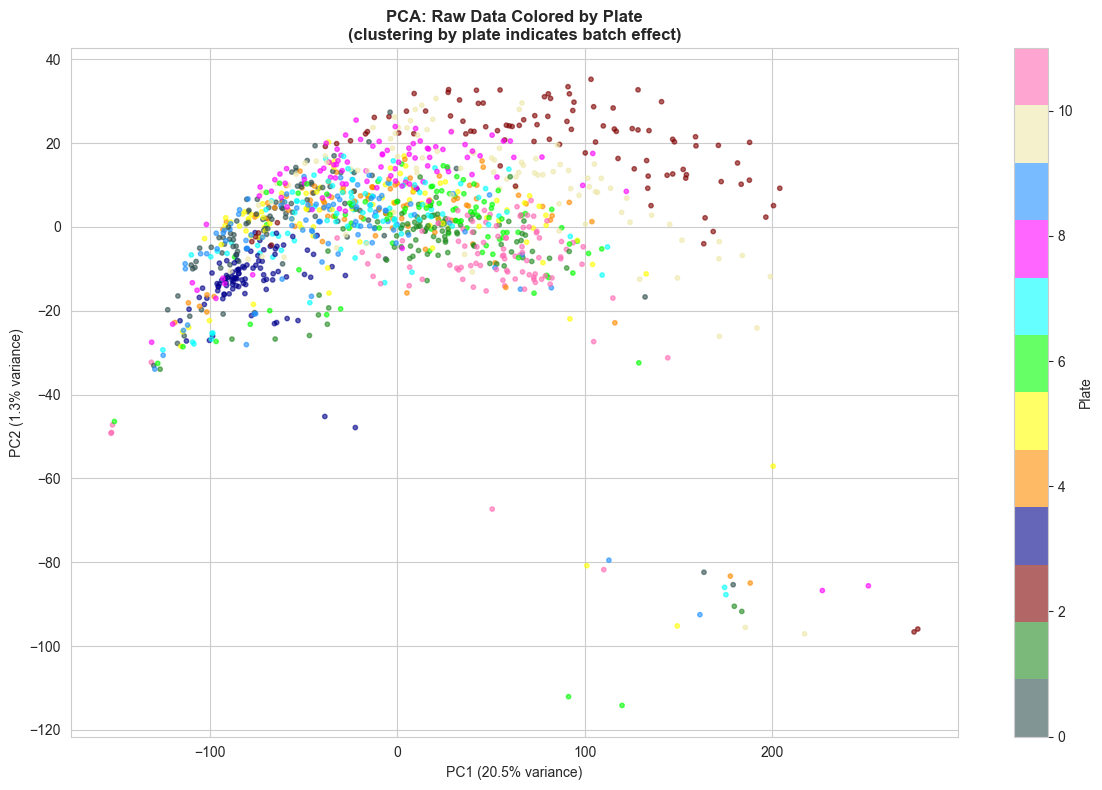

In [12]:
# Visualization 5: PCA colored by plate
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                      c=pca_df['plate'].astype('category').cat.codes, 
                      cmap=mcolors.ListedColormap(twelve_custom_colors), alpha=0.6, s=10)
#                      cmap='Set3', alpha=0.6, s=10)
#                      cmap='tab20', alpha=0.6, s=10)
plt.title('PCA: Raw Data Colored by Plate\n(clustering by plate indicates batch effect)', 
          fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Plate')
plt.tight_layout()
plt.show()


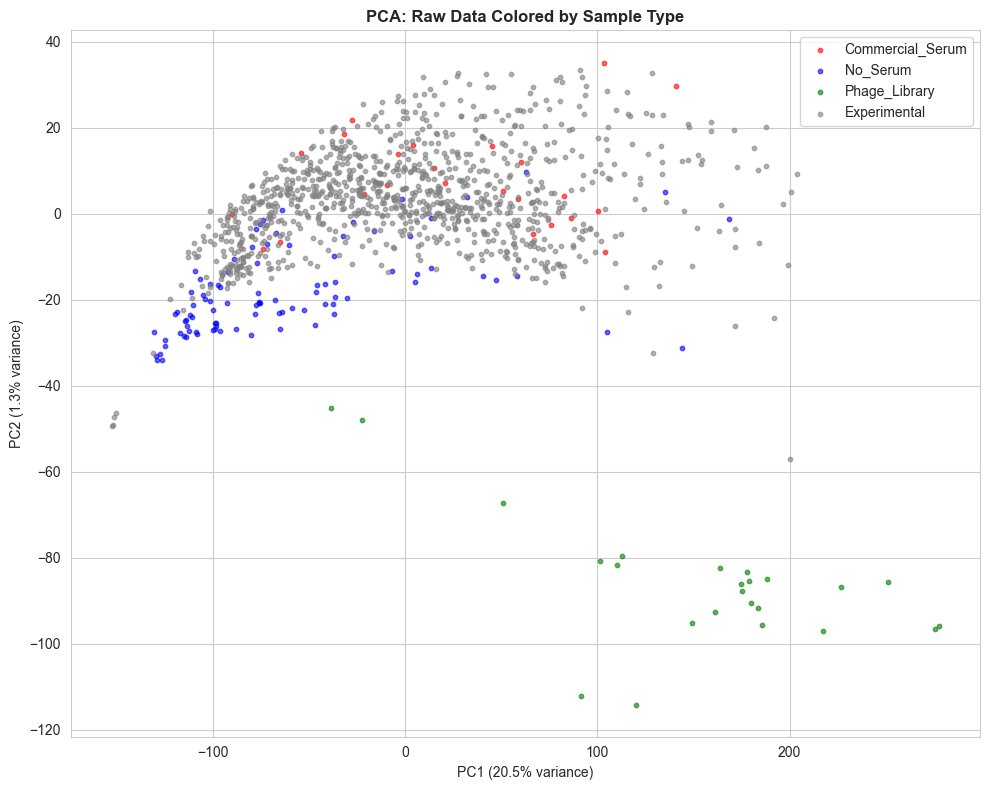

In [13]:
# Visualization 6: PCA colored by sample type
plt.figure(figsize=(10, 8))
sample_type_colors = {'Commercial_Serum': 'red', 'No_Serum': 'blue', 
                      'Phage_Library': 'green', 'Experimental': 'gray'}
for stype, color in sample_type_colors.items():
    mask = pca_df['sample_type'] == stype
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                c=color, label=stype, alpha=0.6, s=10)
plt.title('PCA: Raw Data Colored by Sample Type', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.tight_layout()
plt.show()


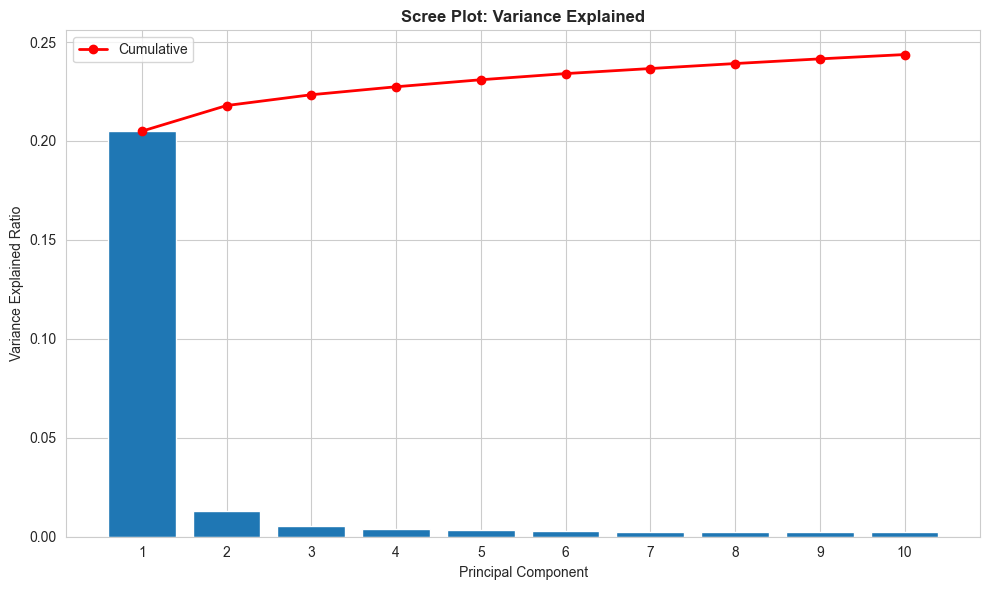

In [14]:
# Visualization 7: Scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_[:10])
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), 
         'r-o', linewidth=2, label='Cumulative')
plt.title('Scree Plot: Variance Explained', fontsize=12, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained Ratio')
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
%%time

print("\n" + "=" * 80)
print("STEP 5: Background Subtraction Using No-Serum Controls (VECTORIZED)")
print("=" * 80)

# No-serum controls measure non-specific binding and background noise
# Subtracting this background improves signal-to-noise ratio
# We calculate median background per plate to account for plate-specific background

# Calculate median background per plate from No-Serum controls
blank_samples = manifest[manifest['sample_type'] == 'No_Serum'].index


if len(blank_samples) == 0:
    print("WARNING: No blank samples found. Skipping background subtraction.")
    data_bg_subtracted = data_matrix.copy()
else:
    print(f"Found {len(blank_samples)} no-serum control samples")
    
    # Calculate plate-specific background using groupby (vectorized)
    blank_data = data_matrix.loc[blank_samples].copy()
    blank_data['plate'] = manifest.loc[blank_samples, 'plate']
    
    # Compute median background for each plate
    plate_backgrounds = blank_data.groupby('plate').median()
    
    # If some plates don't have blanks, use global background
    all_plates = manifest['plate'].unique()
    missing_plates = set(all_plates) - set(plate_backgrounds.index)
    if missing_plates:
        global_background = data_matrix.loc[blank_samples].median(axis=0)
        for plate in missing_plates:
            plate_backgrounds.loc[plate] = global_background
        print(f"Plates without blanks (using global background): {missing_plates}")
    
    print(f"\nPlate-specific background statistics:")
    print(plate_backgrounds.median(axis=1))
    
    # VECTORIZED BACKGROUND SUBTRACTION
    # Create a mapping of sample -> background to subtract
    # This avoids the slow row-by-row loop
    print("Performing vectorized background subtraction...")
    
    # Method: Use DataFrame.sub with axis alignment
    # For each sample, subtract the background from its plate
    #data_bg_subtracted = data_matrix.copy()


    

    # WHY DOES THIS TAKE SOOOOO LOOOONNNNNGGGGG?
    # Never completes because its erroring!
    data_bg_subtracted = data_matrix.copy().astype(float)


    
    # Group samples by plate and subtract in batches (much faster)
    for plate in manifest['plate'].unique():
        print(f"Plate : {plate}")
        plate_mask = manifest['plate'] == plate
        plate_samples = manifest[plate_mask].index
        # Vectorized subtraction for all samples in this plate at once
        data_bg_subtracted.loc[plate_samples] = (
            data_matrix.loc[plate_samples].values - plate_backgrounds.loc[plate].values
        )
    
    # Set negative values to zero (can't have negative counts)
    data_bg_subtracted = data_bg_subtracted.clip(lower=0)
    
    print(f"Background subtraction complete!")
    print(f"Mean reduction: "
          f"{(data_matrix.mean().mean() - data_bg_subtracted.mean().mean()) / data_matrix.mean().mean() * 100:.2f}%")



STEP 5: Background Subtraction Using No-Serum Controls (VECTORIZED)
Found 93 no-serum control samples

Plate-specific background statistics:
plate
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.5
dtype: float64
Performing vectorized background subtraction...
Plate : 14
Plate : 13
Plate : 16
Plate : 3
Plate : 6
Plate : 2
Plate : 5
Plate : 4
Plate : 1
Plate : 15
Plate : 17
Plate : 18
Background subtraction complete!
Mean reduction: 3.85%
CPU times: user 6.48 s, sys: 1.47 s, total: 7.95 s
Wall time: 7.97 s


In [16]:
data_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,128278,128279,128280,128281,128282,128283,128284,128285,128286,128287
sample,,,,,,,,,,,,,,,,,,,,,
024JCM,0,0,0,0,1,0,53,0,0,0,...,0,0,0,0,1,0,0,0,2,0
024JCMdup,0,2,0,0,44,0,3,0,0,0,...,3,0,1,193,0,0,0,0,2,0
043MPL,0,20,0,0,23,0,31,0,0,0,...,0,0,0,20,6,4,0,4,3,0
043MPLdup,0,16,0,0,10,0,4,0,0,0,...,7,0,3,4,13,8,0,0,7,0
074KBP,0,0,0,0,31,0,52,0,18,0,...,0,0,0,0,0,0,1,0,39,7


In [17]:
data_bg_subtracted.head()

,1,2,3,4,5,6,7,8,9,10,...,128278,128279,128280,128281,128282,128283,128284,128285,128286,128287
sample,,,,,,,,,,,,,,,,,,,,,
024JCM,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
024JCMdup,0.0,2.0,0.0,0.0,43.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,1.0,193.0,0.0,0.0,0.0,0.0,2.0,0.0
043MPL,0.0,20.0,0.0,0.0,22.0,0.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,6.0,2.0,0.0,4.0,3.0,0.0
043MPLdup,0.0,16.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,0.0,...,7.0,0.0,3.0,4.0,13.0,6.0,0.0,0.0,7.0,0.0
074KBP,0.0,0.0,0.0,0.0,30.0,0.0,52.0,0.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39.0,7.0


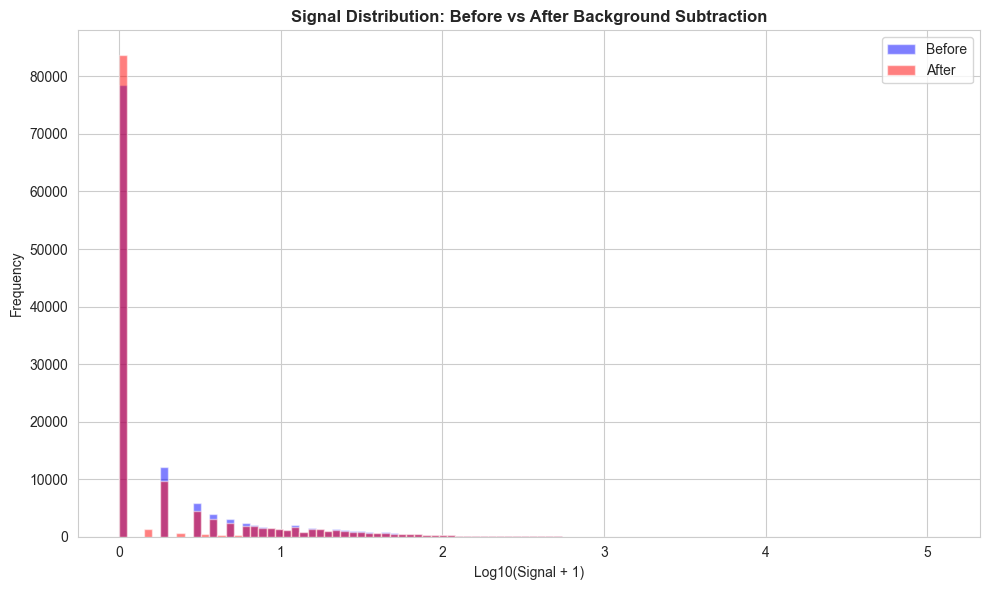

In [18]:
# Visualization 8: Before/After background subtraction distribution
plt.figure(figsize=(10, 6))
plt.hist(np.log10(data_matrix.values.flatten()[::1000] + 1), bins=100, alpha=0.5, 
         label='Before', color='blue')
plt.hist(np.log10(data_bg_subtracted.values.flatten()[::1000] + 1), bins=100, alpha=0.5, 
         label='After', color='red')
plt.title('Signal Distribution: Before vs After Background Subtraction', 
          fontsize=12, fontweight='bold')
plt.xlabel('Log10(Signal + 1)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


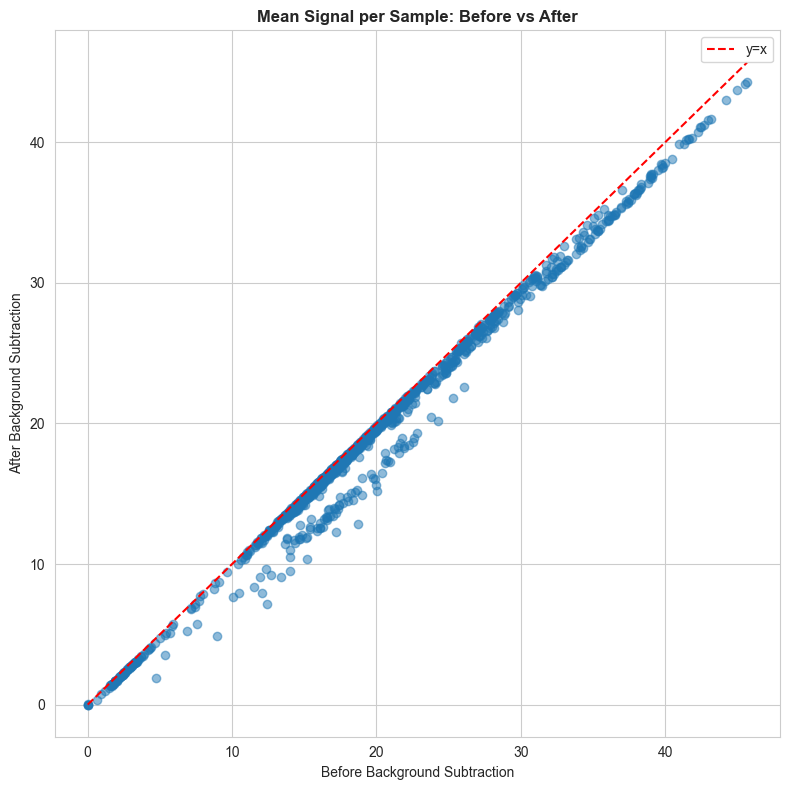

In [19]:
# Visualization 9: Mean signal comparison
plt.figure(figsize=(8, 8))
sample_means_before = data_matrix.mean(axis=1)
sample_means_after = data_bg_subtracted.mean(axis=1)
plt.scatter(sample_means_before, sample_means_after, alpha=0.5)
plt.plot([0, sample_means_before.max()], [0, sample_means_before.max()], 
         'r--', label='y=x')
plt.title('Mean Signal per Sample: Before vs After', fontsize=12, fontweight='bold')
plt.xlabel('Before Background Subtraction')
plt.ylabel('After Background Subtraction')
plt.legend()
plt.tight_layout()
plt.show()


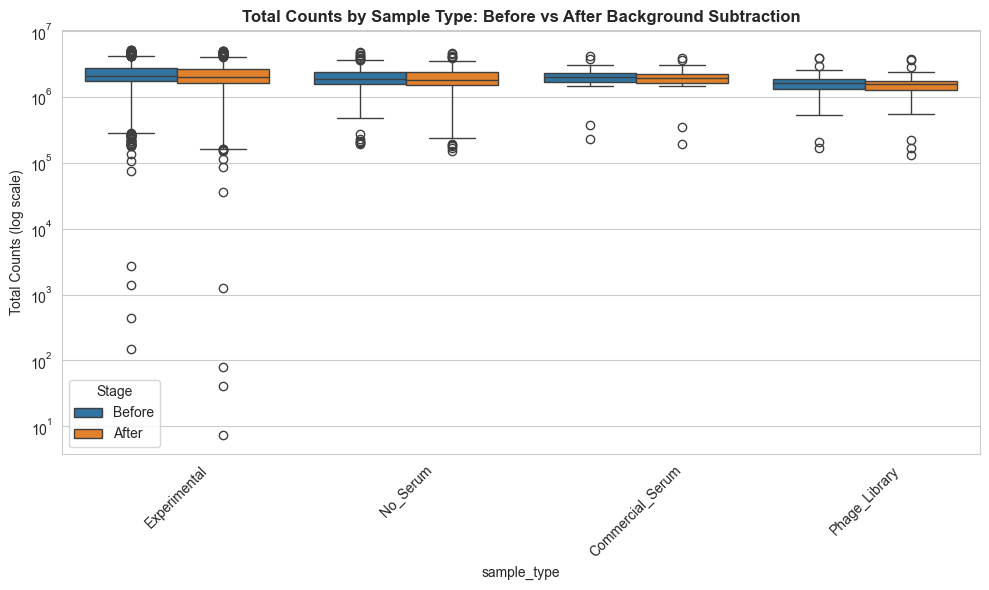

In [20]:
# Visualization 10: Total counts by sample type before/after
plt.figure(figsize=(10, 6))
combined_stats = pd.DataFrame({
    'Before': data_matrix.sum(axis=1),
    'After': data_bg_subtracted.sum(axis=1),
    'sample_type': manifest['sample_type']
})
combined_stats_long = combined_stats.melt(id_vars=['sample_type'], 
                                          var_name='Stage', value_name='Total_Counts')
sns.boxplot(data=combined_stats_long, x='sample_type', y='Total_Counts', hue='Stage')
plt.title('Total Counts by Sample Type: Before vs After Background Subtraction', 
          fontsize=12, fontweight='bold')
plt.ylabel('Total Counts (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
%%time

print("\n" + "=" * 80)
print("STEP 6: Library Size Normalization (Total Count Scaling)")
print("=" * 80)

# Normalize by total counts (library size) to account for differences in
# sequencing depth or overall signal strength across samples
# This is similar to CPM (counts per million) normalization

# Calculate library sizes (total counts per sample)
library_sizes = data_bg_subtracted.sum(axis=1)
median_library_size = library_sizes.median()

print(f"Library size range: {library_sizes.min():.0f} - {library_sizes.max():.0f}")
print(f"Median library size: {median_library_size:.0f}")
print(f"Library size CV: {library_sizes.std() / library_sizes.mean():.3f}")

# VECTORIZED NORMALIZATION
# Calculate scaling factors for all samples at once
scaling_factors = median_library_size / library_sizes

# Apply scaling factors using broadcasting (much faster than loops)
data_normalized = data_bg_subtracted.mul(scaling_factors, axis=0)

print(f"\nLibrary sizes after normalization:")
print(f"Range: {data_normalized.sum(axis=1).min():.0f} - {data_normalized.sum(axis=1).max():.0f}")
print(f"CV: {data_normalized.sum(axis=1).std() / data_normalized.sum(axis=1).mean():.6f}")



STEP 6: Library Size Normalization (Total Count Scaling)
Library size range: 8 - 5107867
Median library size: 1995126
Library size CV: 0.461

Library sizes after normalization:
Range: 1995125 - 1995126
CV: 0.000000
CPU times: user 1.59 s, sys: 310 ms, total: 1.91 s
Wall time: 1.93 s


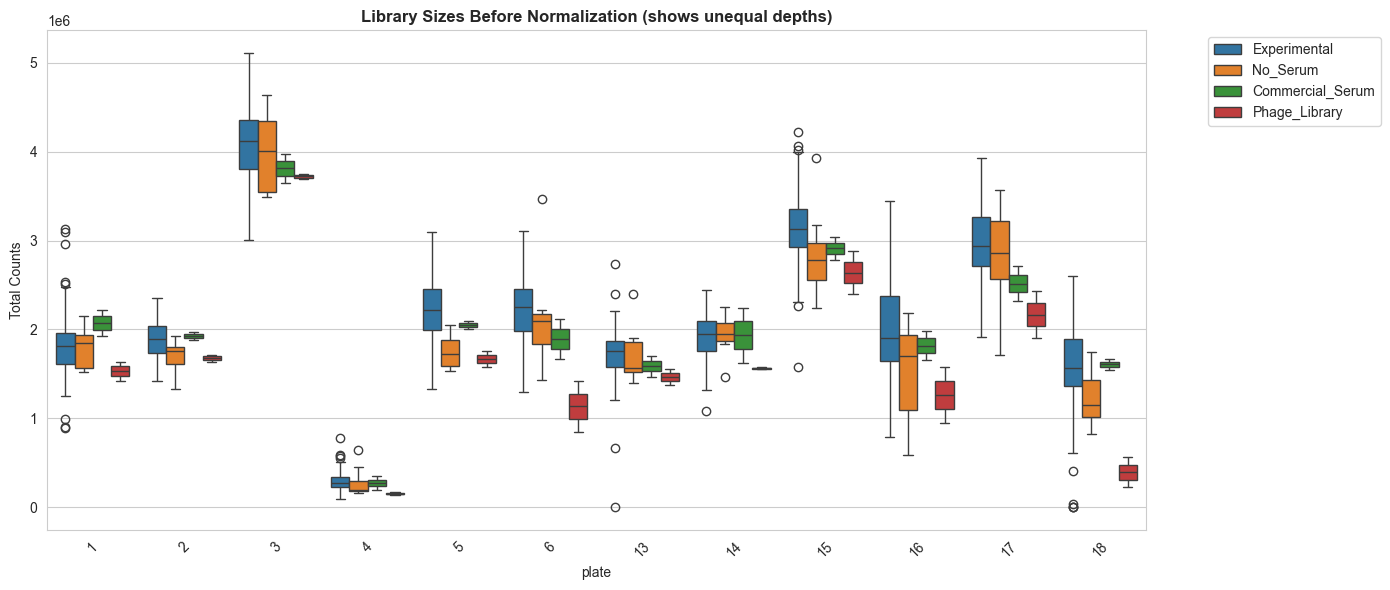

In [22]:
# Visualization 11: Library sizes before normalization
plt.figure(figsize=(14, 6))
lib_stats = pd.DataFrame({
    'library_size': library_sizes,
    'sample_type': manifest['sample_type'],
    'plate': manifest['plate']
})
sns.boxplot(data=lib_stats, x='plate', y='library_size', hue='sample_type')
plt.title('Library Sizes Before Normalization (shows unequal depths)', 
          fontsize=12, fontweight='bold')
plt.ylabel('Total Counts')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


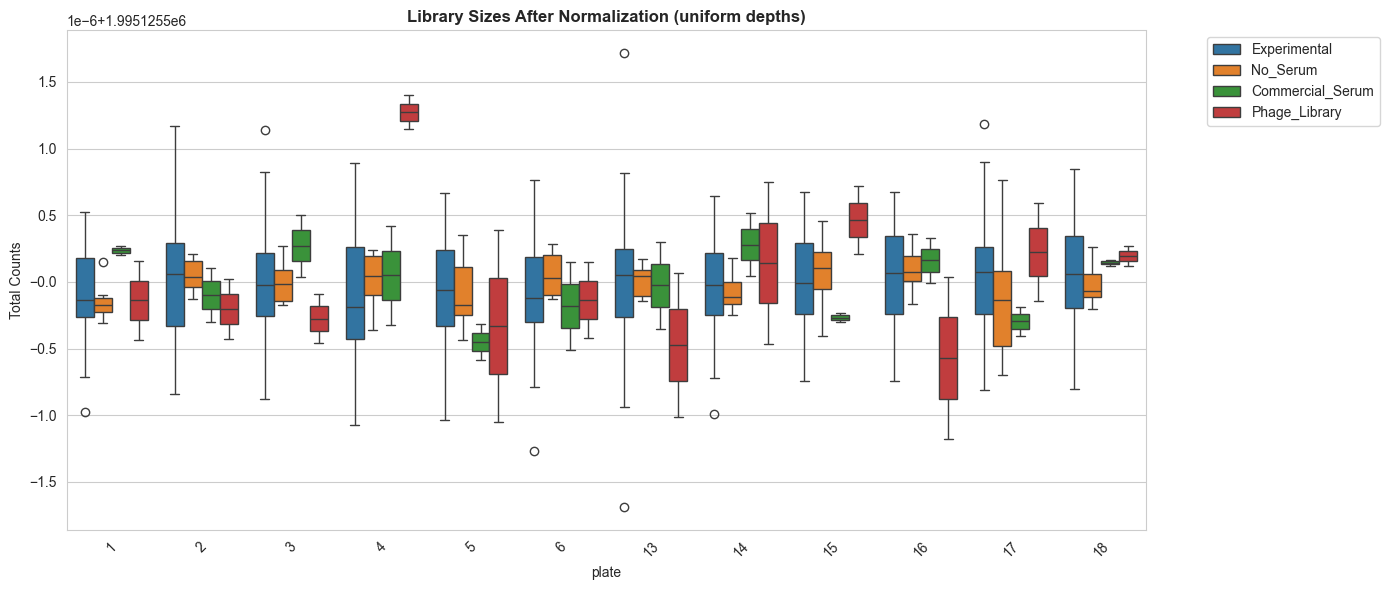

In [23]:
# Visualization 12: Library sizes after normalization
plt.figure(figsize=(14, 6))
lib_stats_after = pd.DataFrame({
    'library_size': data_normalized.sum(axis=1),
    'sample_type': manifest['sample_type'],
    'plate': manifest['plate']
})
sns.boxplot(data=lib_stats_after, x='plate', y='library_size', hue='sample_type')
plt.title('Library Sizes After Normalization (uniform depths)', 
          fontsize=12, fontweight='bold')
plt.ylabel('Total Counts')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


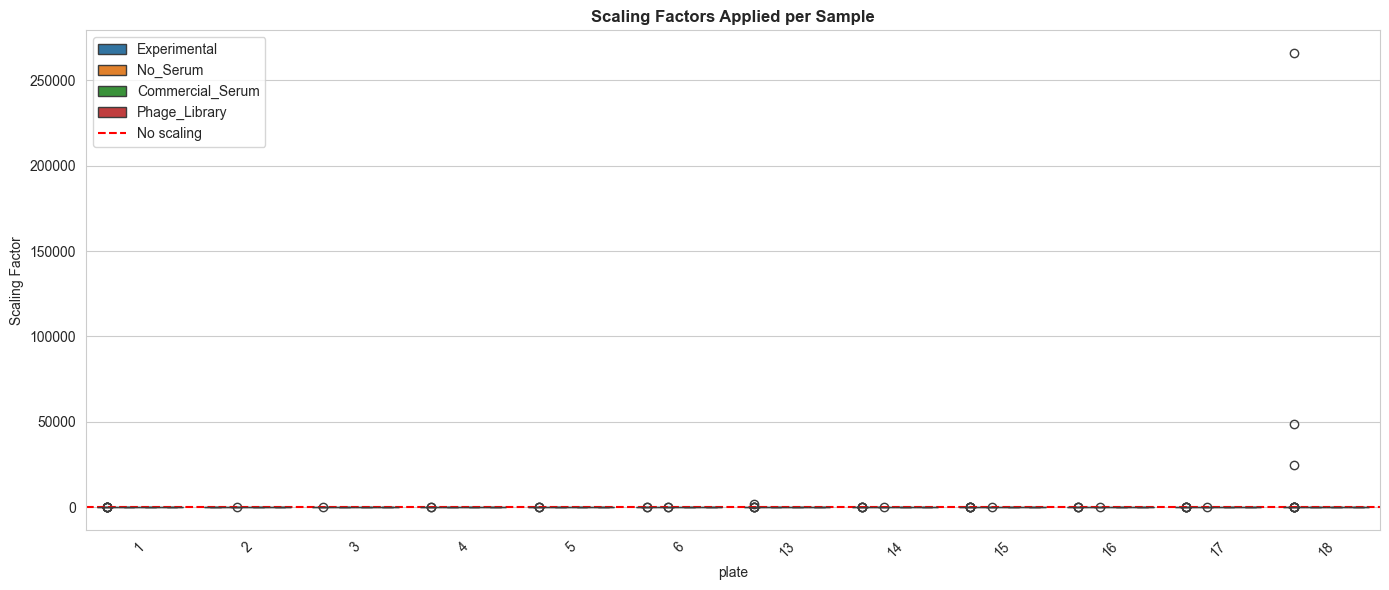

In [24]:
# Visualization 13: Scaling factors
plt.figure(figsize=(14, 6))
scaling_df = pd.DataFrame({
    'scaling_factor': scaling_factors,
    'sample_type': manifest['sample_type'],
    'plate': manifest['plate']
})
sns.boxplot(data=scaling_df, x='plate', y='scaling_factor', hue='sample_type')
plt.title('Scaling Factors Applied per Sample', fontsize=12, fontweight='bold')
plt.ylabel('Scaling Factor')
plt.axhline(y=1, color='r', linestyle='--', label='No scaling')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
%%time

print("\n" + "=" * 80)
print("STEP 7: Plate Effect Correction Using Commercial Serum Controls (VECTORIZED)")
print("=" * 80)

# Commercial serum controls are consistent biological material run on each plate
# They should have similar signals across plates; differences indicate plate effects
# We use these to calculate plate-specific correction factors

cse_samples = manifest[manifest['sample_type'] == 'Commercial_Serum'].index

if len(cse_samples) == 0:
    print("WARNING: No commercial serum samples found. Skipping plate correction.")
    data_plate_corrected = data_normalized.copy()
else:
    print(f"Found {len(cse_samples)} commercial serum samples across plates")
    
    # Calculate global median for each peptide across all CSE samples
    # This represents the "true" expected signal for each peptide
    global_cse_median = data_normalized.loc[cse_samples].median(axis=0)
    
    # Calculate plate-specific median for each peptide using groupby (vectorized)
    cse_data = data_normalized.loc[cse_samples].copy()
    cse_data['plate'] = manifest.loc[cse_samples, 'plate']
    
    # Compute median CSE signal for each plate
    plate_cse_median = cse_data.groupby('plate').median()
    
    # Calculate correction factors (global / plate-specific)
    # If plate has higher signal, factor < 1 (scale down)
    # If plate has lower signal, factor > 1 (scale up)
    plate_correction_factors = global_cse_median / (plate_cse_median + 1e-10)
    
    # Replace infinite or very large values with 1 (no correction)
    plate_correction_factors = plate_correction_factors.replace([np.inf, -np.inf], 1)
    plate_correction_factors = plate_correction_factors.clip(lower=0.1, upper=10)
    
    # Handle plates without CSE samples
    all_plates = manifest['plate'].unique()
    missing_plates = set(all_plates) - set(plate_correction_factors.index)
    if missing_plates:
        for plate in missing_plates:
            plate_correction_factors.loc[plate] = 1.0
        print(f"Plates without CSE samples (no correction): {missing_plates}")
    
    print(f"\nMedian correction factors by plate:")
    print(plate_correction_factors.median(axis=1))
    
    # VECTORIZED PLATE CORRECTION
    # Apply corrections in batches by plate (much faster than row-by-row)
    print("Performing vectorized plate correction...")
    data_plate_corrected = data_normalized.copy()
    
    for plate in manifest['plate'].unique():
        plate_mask = manifest['plate'] == plate
        plate_samples = manifest[plate_mask].index
        # Vectorized multiplication for all samples in this plate at once
        data_plate_corrected.loc[plate_samples] = (
            data_normalized.loc[plate_samples].values * 
            plate_correction_factors.loc[plate].values
        )
    
    # Recalculate library sizes after plate correction and re-normalize
    library_sizes_after_pc = data_plate_corrected.sum(axis=1)
    median_size_after_pc = library_sizes_after_pc.median()
    scaling_factors_pc = median_size_after_pc / library_sizes_after_pc
    data_plate_corrected = data_plate_corrected.mul(scaling_factors_pc, axis=0)
    
    print(f"Plate effect correction complete!")



STEP 7: Plate Effect Correction Using Commercial Serum Controls (VECTORIZED)
Found 24 commercial serum samples across plates

Median correction factors by plate:
plate
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
dtype: float64
Performing vectorized plate correction...
Plate effect correction complete!
CPU times: user 5.34 s, sys: 917 ms, total: 6.26 s
Wall time: 6.27 s


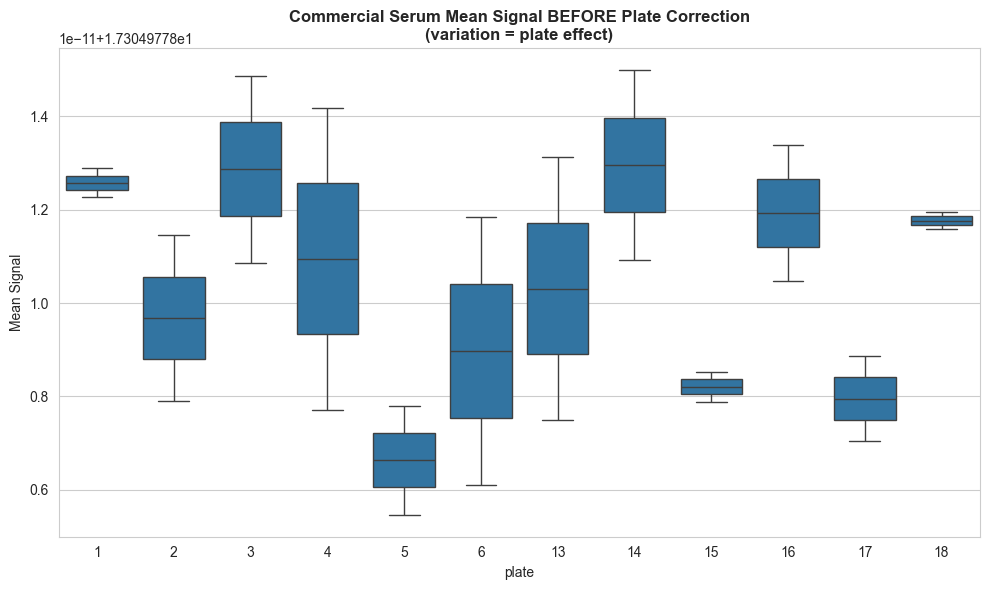

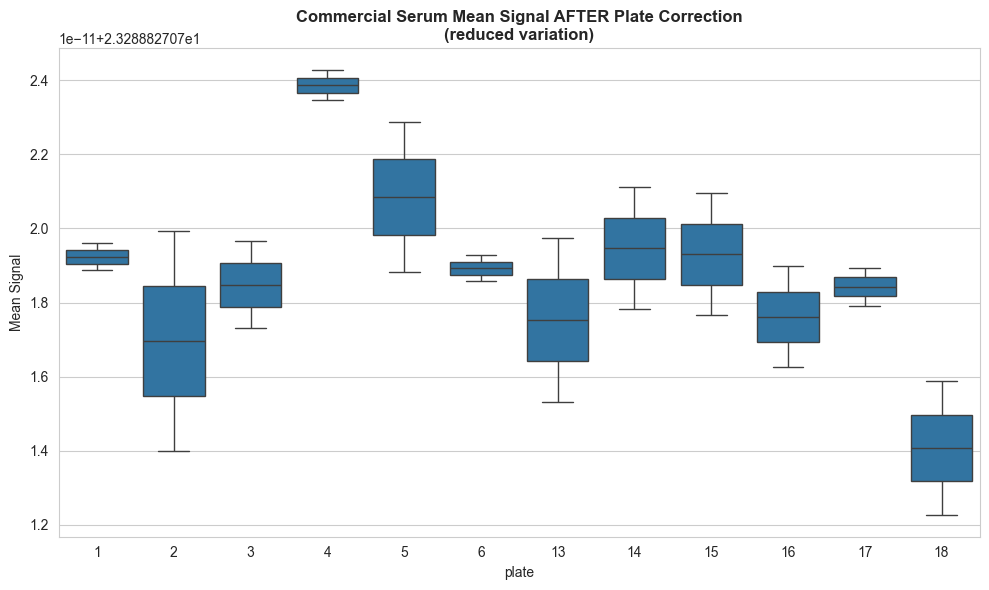


CSE signal CV across plates:
Before correction: 0.000
After correction: 0.000
Improvement: 35.9%


In [26]:
# Visualization 14: CSE signal consistency before correction
if len(cse_samples) > 0:
    plt.figure(figsize=(10, 6))
    cse_stats_before = pd.DataFrame({
        'mean_signal': data_normalized.loc[cse_samples].mean(axis=1),
        'plate': manifest.loc[cse_samples, 'plate']
    })
    sns.boxplot(data=cse_stats_before, x='plate', y='mean_signal')
    plt.title('Commercial Serum Mean Signal BEFORE Plate Correction\n(variation = plate effect)', 
              fontsize=12, fontweight='bold')
    plt.ylabel('Mean Signal')
    plt.tight_layout()
    plt.show()
    
    # Visualization 15: CSE signal consistency after correction
    plt.figure(figsize=(10, 6))
    cse_stats_after = pd.DataFrame({
        'mean_signal': data_plate_corrected.loc[cse_samples].mean(axis=1),
        'plate': manifest.loc[cse_samples, 'plate']
    })
    sns.boxplot(data=cse_stats_after, x='plate', y='mean_signal')
    plt.title('Commercial Serum Mean Signal AFTER Plate Correction\n(reduced variation)', 
              fontsize=12, fontweight='bold')
    plt.ylabel('Mean Signal')
    plt.tight_layout()
    plt.show()
    
    # Calculate CV improvement
    cv_before = cse_stats_before.groupby('plate')['mean_signal'].std() / \
                cse_stats_before.groupby('plate')['mean_signal'].mean()
    cv_after = cse_stats_after.groupby('plate')['mean_signal'].std() / \
               cse_stats_after.groupby('plate')['mean_signal'].mean()
    
    print(f"\nCSE signal CV across plates:")
    print(f"Before correction: {cv_before.mean():.3f}")
    print(f"After correction: {cv_after.mean():.3f}")
    print(f"Improvement: {(1 - cv_after.mean()/cv_before.mean()) * 100:.1f}%")


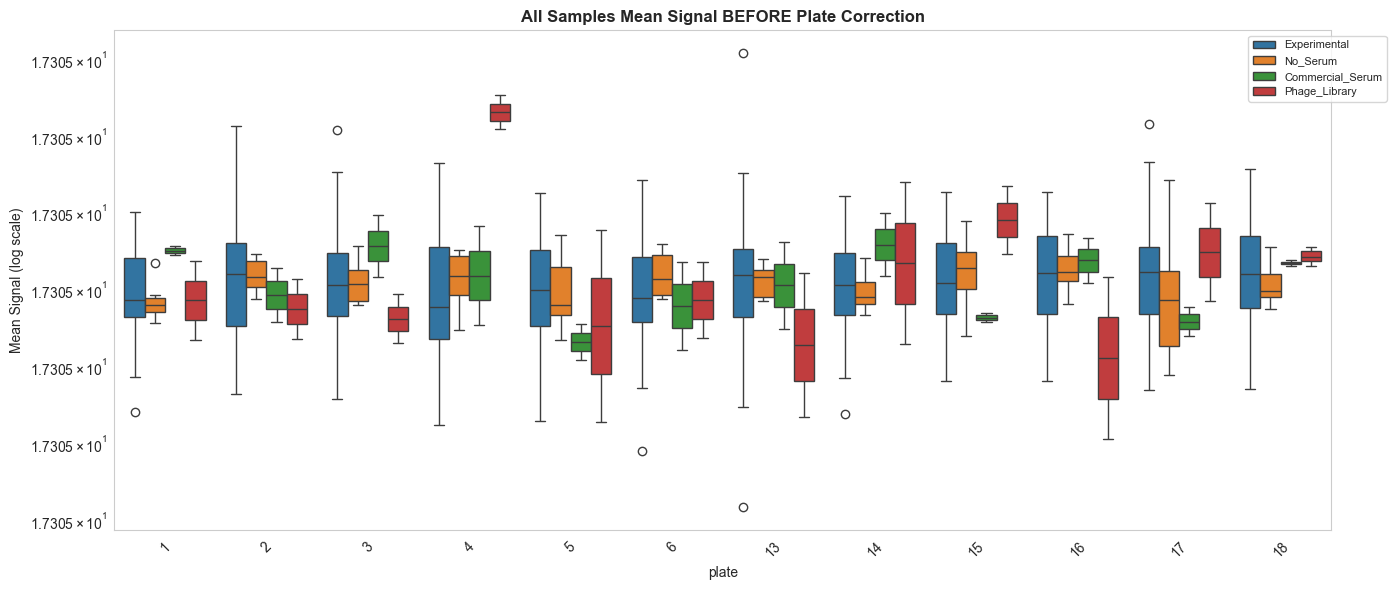

In [27]:
# Visualization 16: All samples before correction
plt.figure(figsize=(14, 6))
all_stats_before = pd.DataFrame({
    'mean_signal': data_normalized.mean(axis=1),
    'sample_type': manifest['sample_type'],
    'plate': manifest['plate']
})
sns.boxplot(data=all_stats_before, x='plate', y='mean_signal', hue='sample_type')
plt.title('All Samples Mean Signal BEFORE Plate Correction', 
          fontsize=12, fontweight='bold')
plt.ylabel('Mean Signal (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


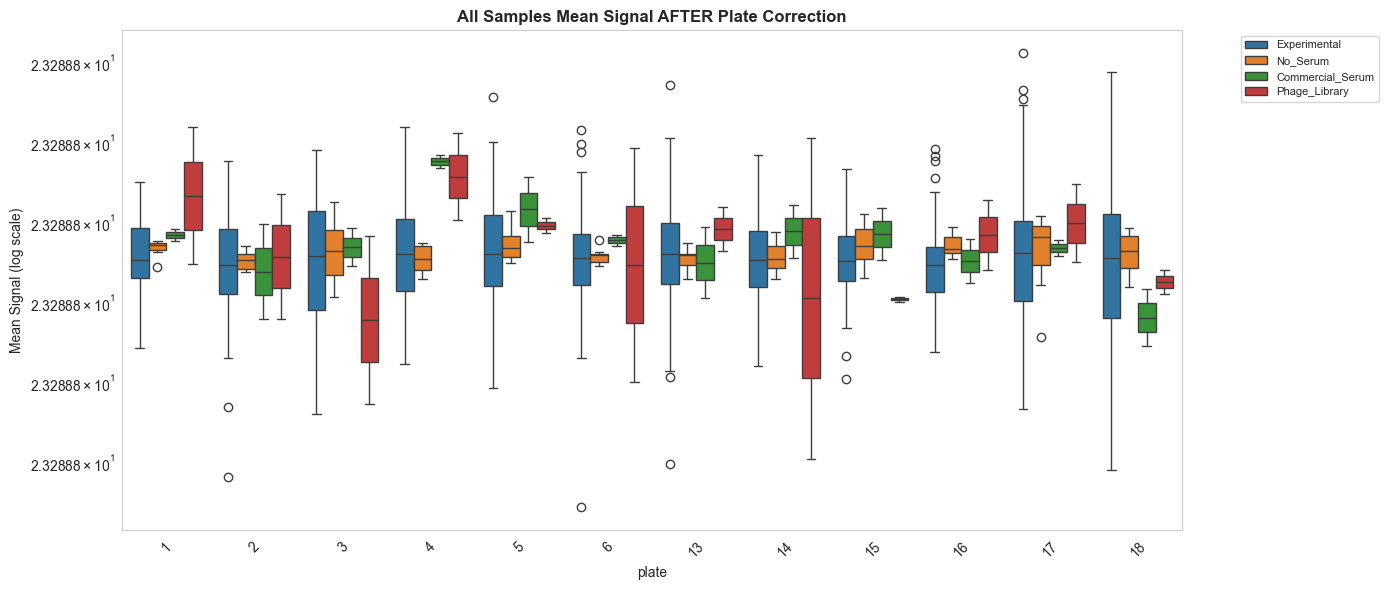

In [28]:
# Visualization 17: All samples after correction
plt.figure(figsize=(14, 6))
all_stats_after = pd.DataFrame({
    'mean_signal': data_plate_corrected.mean(axis=1),
    'sample_type': manifest['sample_type'],
    'plate': manifest['plate']
})
sns.boxplot(data=all_stats_after, x='plate', y='mean_signal', hue='sample_type')
plt.title('All Samples Mean Signal AFTER Plate Correction', 
          fontsize=12, fontweight='bold')
plt.ylabel('Mean Signal (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [29]:
%%time

print("\n" + "=" * 80)
print("STEP 8: Final Normalization - Log Transformation and Z-scoring")
print("=" * 80)

# Log transformation stabilizes variance and makes data more normally distributed
# This is critical for downstream statistical analysis
data_log_final = np.log10(data_plate_corrected + 1)

# Z-score normalization (standardization) per peptide
# Centers each peptide to mean=0, std=1 across all samples
# This makes peptides with different dynamic ranges comparable
scaler = StandardScaler()
data_zscored = pd.DataFrame(
    scaler.fit_transform(data_log_final),
    index=data_log_final.index,
    columns=data_log_final.columns
)

print(f"Log-transformed data range: {data_log_final.min().min():.3f} to {data_log_final.max().max():.3f}")
print(f"Z-scored data range: {data_zscored.min().min():.3f} to {data_zscored.max().max():.3f}")
print(f"Z-scored data mean: {data_zscored.mean().mean():.6f}")
print(f"Z-scored data std: {data_zscored.std().mean():.6f}")



STEP 8: Final Normalization - Log Transformation and Z-scoring
Log-transformed data range: 0.000 to 6.174
Z-scored data range: -3.174 to 33.882
Z-scored data mean: -0.000000
Z-scored data std: 1.000435
CPU times: user 5.5 s, sys: 1.85 s, total: 7.35 s
Wall time: 7.36 s


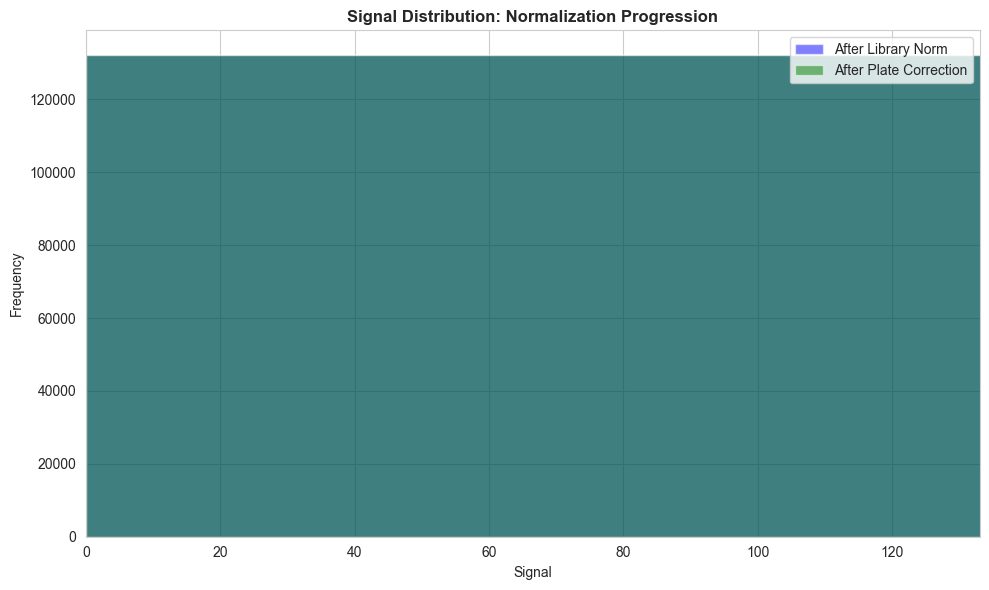

In [30]:
# Visualization 18: Distribution progression
plt.figure(figsize=(10, 6))
plt.hist(data_normalized.values.flatten()[::1000], bins=100, alpha=0.5, 
         label='After Library Norm', color='blue')
plt.hist(data_plate_corrected.values.flatten()[::1000], bins=100, alpha=0.5, 
         label='After Plate Correction', color='green')
plt.title('Signal Distribution: Normalization Progression', fontsize=12, fontweight='bold')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.xlim(0, np.percentile(data_normalized.values.flatten(), 99))
plt.legend()
plt.tight_layout()
plt.show()


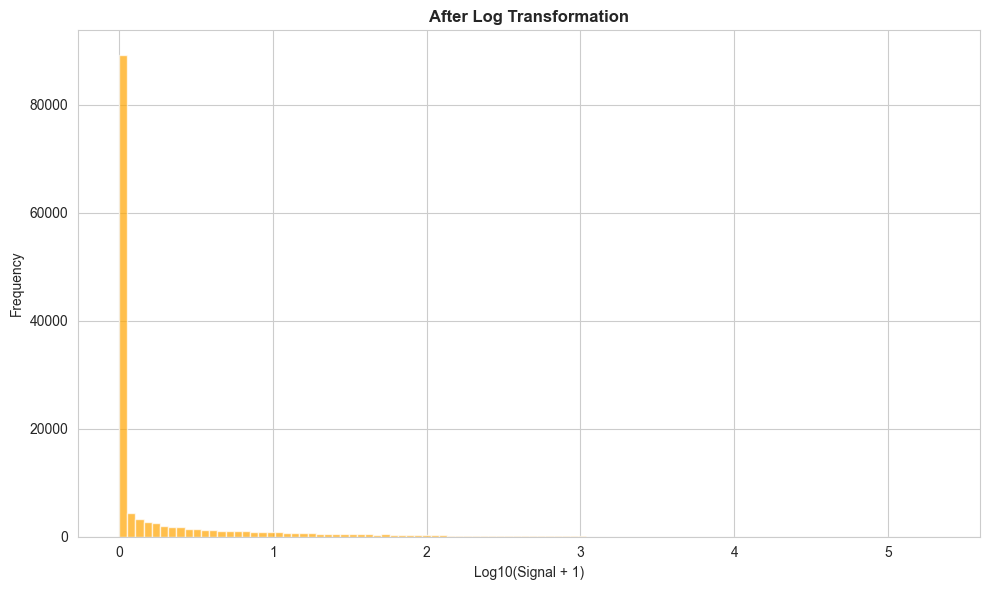

In [31]:
# Visualization 19: Log transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(data_log_final.values.flatten()[::1000], bins=100, alpha=0.7, color='orange')
plt.title('After Log Transformation', fontsize=12, fontweight='bold')
plt.xlabel('Log10(Signal + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


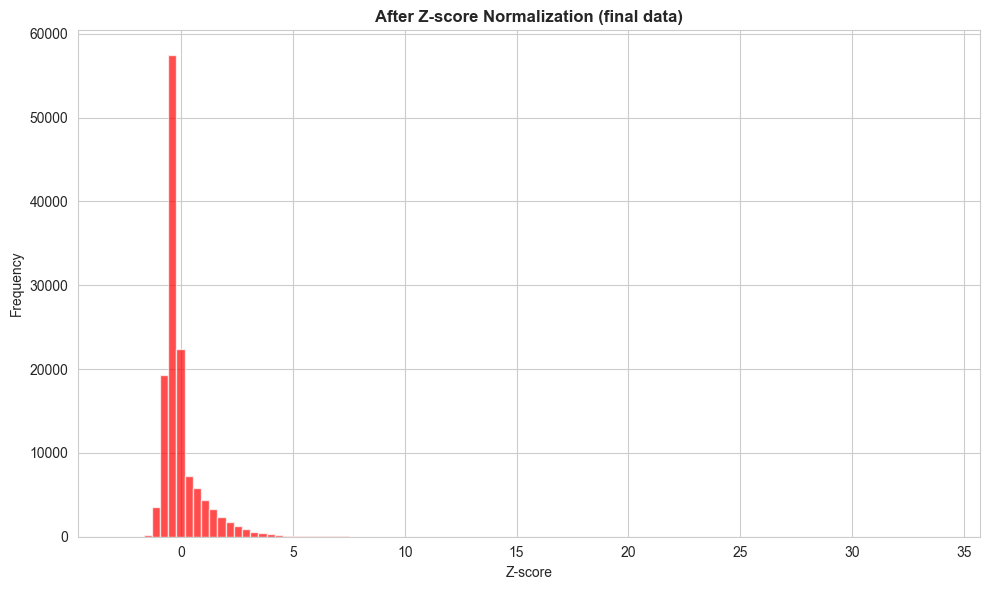

In [32]:
# Visualization 20: Z-scored distribution
plt.figure(figsize=(10, 6))
plt.hist(data_zscored.values.flatten()[::1000], bins=100, alpha=0.7, color='red')
plt.title('After Z-score Normalization (final data)', fontsize=12, fontweight='bold')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


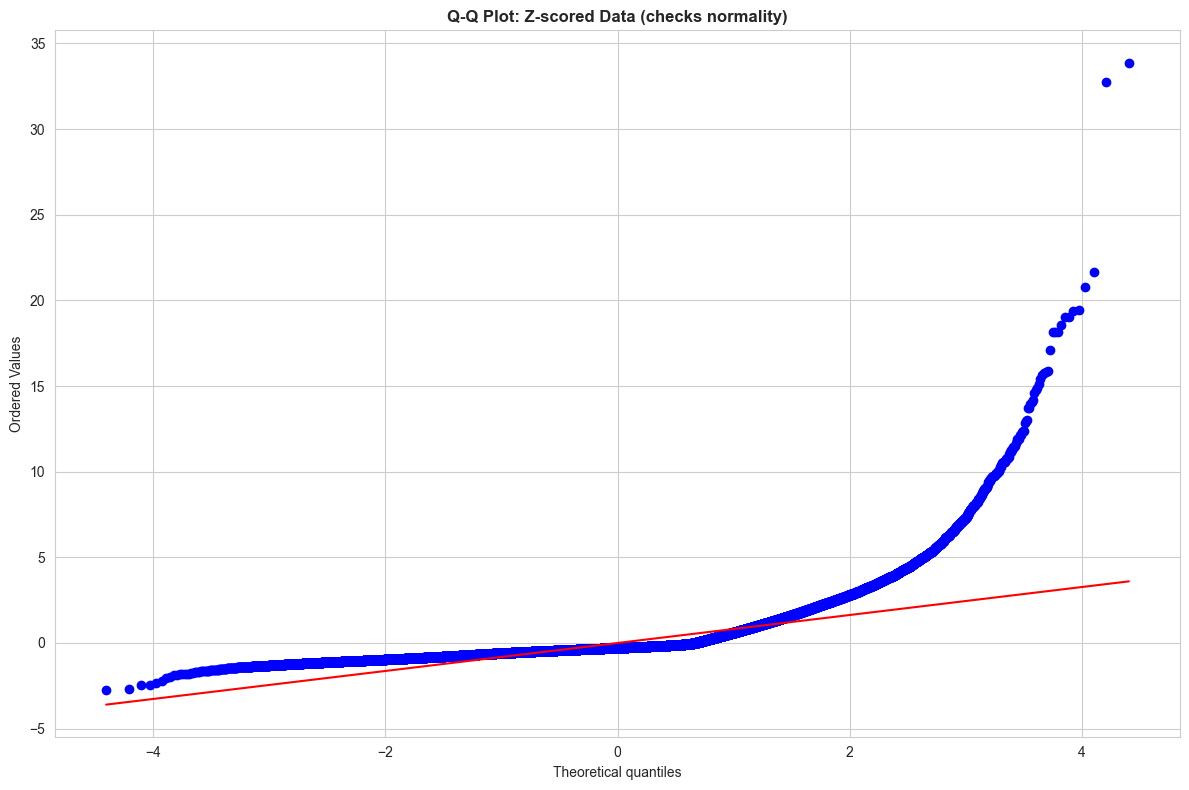

In [33]:
# Visualization 21: Q-Q plot
plt.figure(figsize=(12, 8))
stats.probplot(data_zscored.values.flatten()[::1000], dist="norm", plot=plt)
plt.title('Q-Q Plot: Z-scored Data (checks normality)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


In [34]:
%%time

print("\n" + "=" * 80)
print("STEP 9: PCA on Fully Normalized Data")
print("=" * 80)

# Perform PCA on final normalized data to assess correction effectiveness
pca_final = PCA(n_components=10)
pca_result_final = pca_final.fit_transform(data_zscored)
pca_df_final = pd.DataFrame(pca_result_final[:, :5], 
                            columns=[f'PC{i+1}' for i in range(5)],
                            index=data_zscored.index)
pca_df_final = pd.concat([pca_df_final, manifest], axis=1)

print(f"Explained variance ratio (first 5 PCs): {pca_final.explained_variance_ratio_[:5]}")
print(f"Cumulative variance explained: {np.cumsum(pca_final.explained_variance_ratio_[:5])}")

# Compare with raw PCA
print(f"\nVariance explained by PC1:")
print(f"  Raw data: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  Normalized data: {pca_final.explained_variance_ratio_[0]:.1%}")



STEP 9: PCA on Fully Normalized Data
Explained variance ratio (first 5 PCs): [0.0876037  0.01558933 0.01183047 0.00854942 0.0083939 ]
Cumulative variance explained: [0.0876037  0.10319304 0.11502351 0.12357293 0.13196683]

Variance explained by PC1:
  Raw data: 20.5%
  Normalized data: 8.8%
CPU times: user 33.9 s, sys: 940 ms, total: 34.8 s
Wall time: 4.33 s


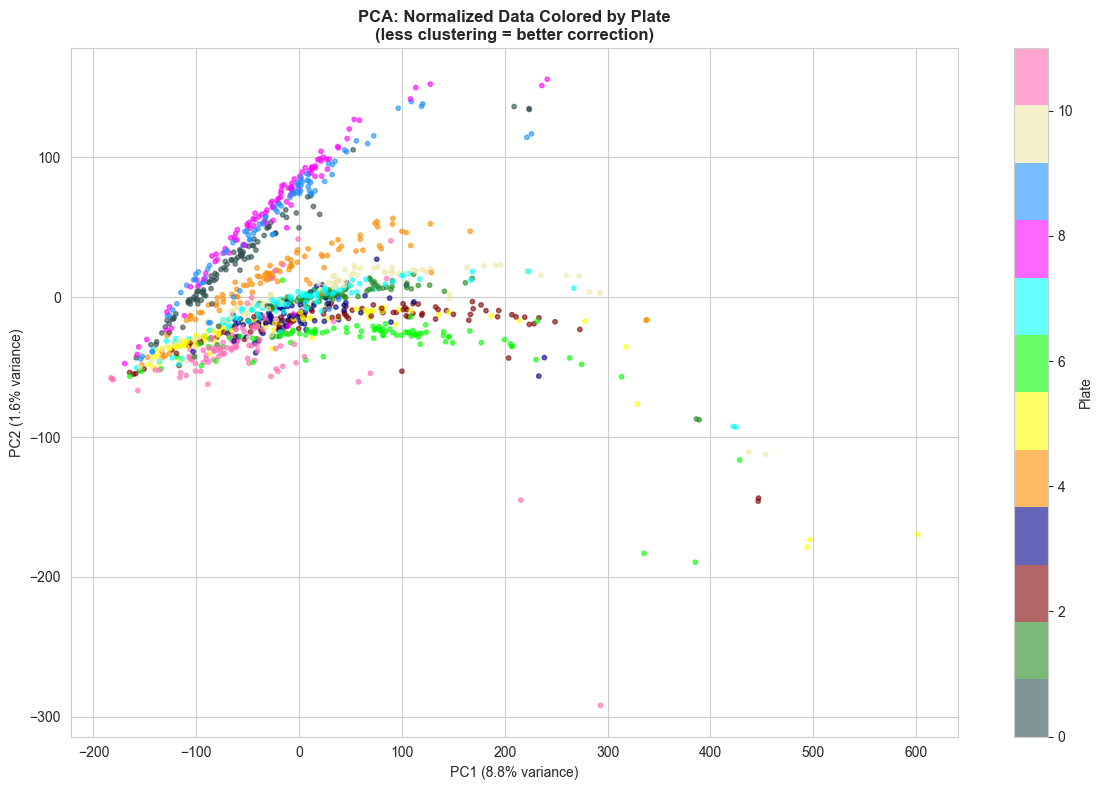

In [35]:
# Visualization 22: PCA colored by plate
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df_final['PC1'], pca_df_final['PC2'], 
                      c=pca_df_final['plate'].astype('category').cat.codes, 
                      cmap=mcolors.ListedColormap(twelve_custom_colors), alpha=0.6, s=10)
#                      cmap='tab20', alpha=0.6, s=10)
plt.title('PCA: Normalized Data Colored by Plate\n(less clustering = better correction)', 
          fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Plate')
plt.tight_layout()
plt.show()


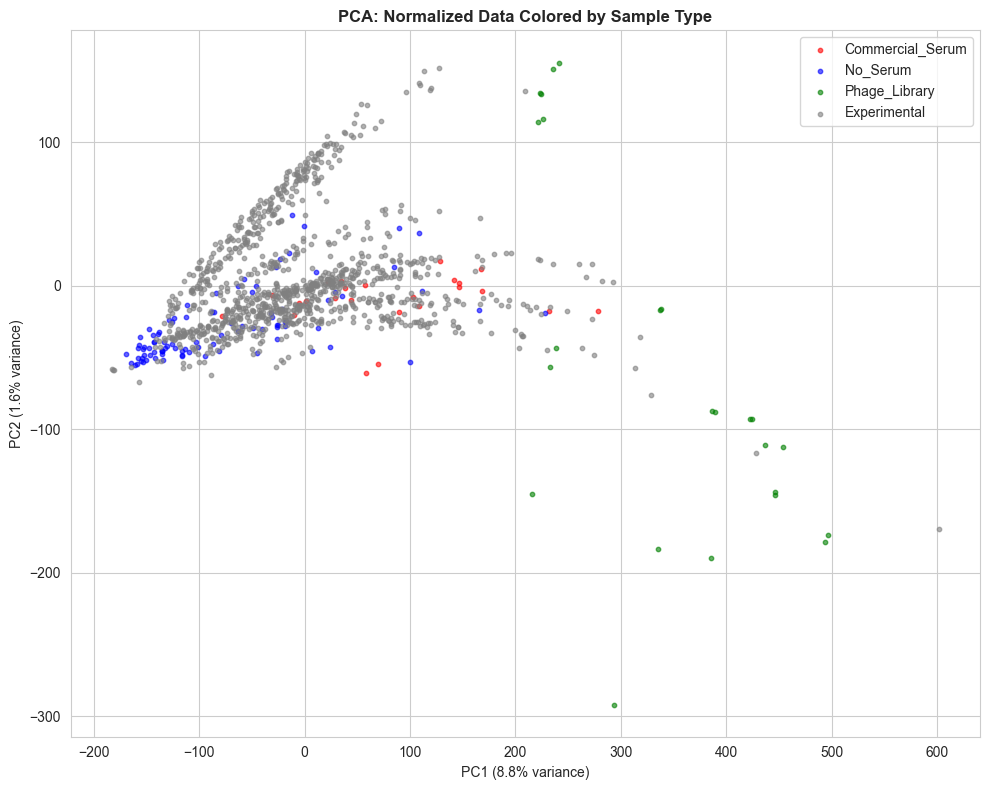

In [36]:
# Visualization 23: PCA colored by sample type
plt.figure(figsize=(10, 8))
for stype, color in sample_type_colors.items():
    mask = pca_df_final['sample_type'] == stype
    plt.scatter(pca_df_final.loc[mask, 'PC1'], pca_df_final.loc[mask, 'PC2'], 
                c=color, label=stype, alpha=0.6, s=10)
plt.title('PCA: Normalized Data Colored by Sample Type', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.tight_layout()
plt.show()


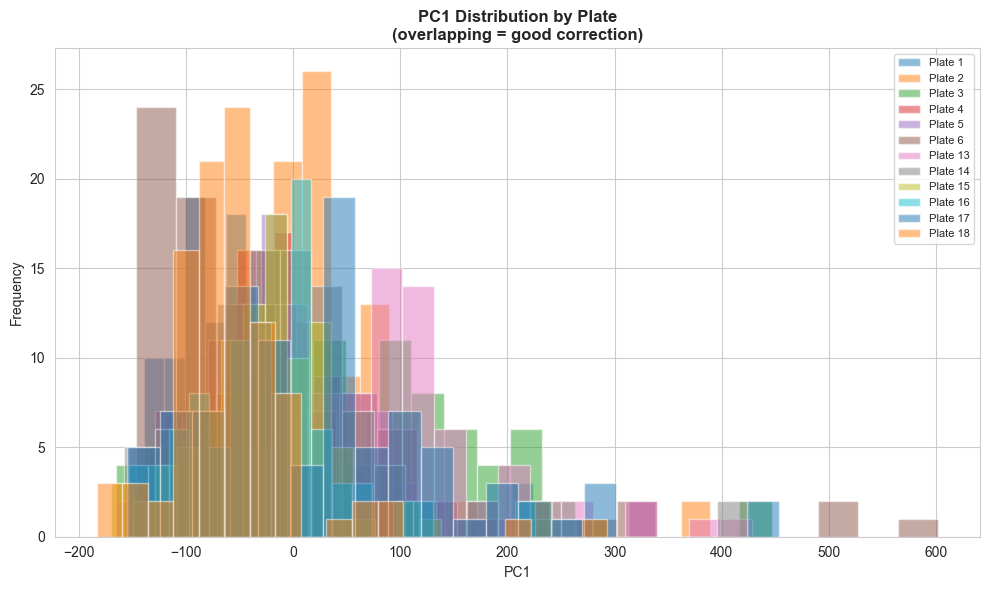

In [37]:
# Visualization 24: PC1 distribution by plate
plt.figure(figsize=(10, 6))
for plate in sorted(pca_df_final['plate'].unique()):
    plate_data = pca_df_final[pca_df_final['plate'] == plate]['PC1']
    plt.hist(plate_data, alpha=0.5, label=f'Plate {plate}', bins=20)
plt.title('PC1 Distribution by Plate\n(overlapping = good correction)', 
          fontsize=12, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


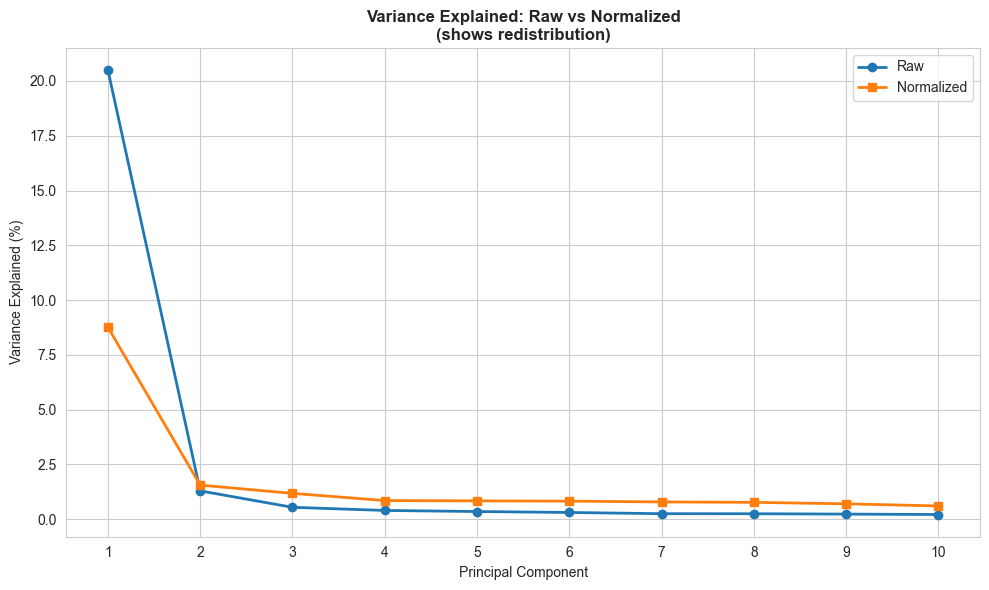

In [38]:
# Visualization 25: Variance comparison
plt.figure(figsize=(10, 6))
comparison_df = pd.DataFrame({
    'PC': range(1, 11),
    'Raw': pca.explained_variance_ratio_[:10] * 100,
    'Normalized': pca_final.explained_variance_ratio_[:10] * 100
})
plt.plot(comparison_df['PC'], comparison_df['Raw'], 'o-', label='Raw', linewidth=2)
plt.plot(comparison_df['PC'], comparison_df['Normalized'], 's-', 
         label='Normalized', linewidth=2)
plt.title('Variance Explained: Raw vs Normalized\n(shows redistribution)', 
          fontsize=12, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.legend()
plt.xticks(range(1, 11))
plt.tight_layout()
plt.show()


In [39]:
%%time

print("\n" + "=" * 80)
print("STEP 10: Merging Technical Replicates (VECTORIZED)")
print("=" * 80)

# Most subjects have 2 replicates that should be merged
# We'll use median to combine replicates (more robust than mean)

# Count replicates
replicate_counts = manifest.groupby('subject').size()
print(f"\nSubjects with replicates:")
print(replicate_counts.value_counts().sort_index())
print(f"Total unique subjects: {len(replicate_counts)}")

# VECTORIZED REPLICATE MERGING
# Use groupby with median aggregation (much faster than loops)
print("Performing vectorized replicate merging...")

# Merge data using groupby median
data_with_subject = data_zscored.copy()
data_with_subject['subject'] = manifest['subject']
data_final = data_with_subject.groupby('subject').median()



STEP 10: Merging Technical Replicates (VECTORIZED)

Subjects with replicates:
1      3
2    569
4      2
Name: count, dtype: int64
Total unique subjects: 574
Performing vectorized replicate merging...
CPU times: user 1.98 s, sys: 721 ms, total: 2.7 s
Wall time: 2.73 s


In [40]:
%%time

# Create merged manifest using groupby aggregations
manifest_aggregations = {
    'sample_type': 'first',
    'study': 'first',
    'group': 'first',
    'age': 'first',
    'sex': 'first',
    'plate': lambda x: ','.join(map(str, sorted(x.unique())))
}

manifest_final = manifest.groupby('subject').agg(manifest_aggregations)
manifest_final['n_replicates'] = manifest.groupby('subject').size()

# Create samples column (comma-separated list of sample IDs)
samples_per_subject = manifest.reset_index().groupby('subject')['sample'].apply(
    lambda x: ','.join(x)
)
manifest_final['samples'] = samples_per_subject

print(f"\nFinal dataset after merging:")
print(f"Subjects: {data_final.shape[0]}")
print(f"Peptides: {data_final.shape[1]}")
print(f"\nSample types in final dataset:")
print(manifest_final['sample_type'].value_counts())

# Calculate replicate correlations for subjects with exactly 2 replicates
print("\nCalculating replicate correlations...")
subjects_with_2_reps = replicate_counts[replicate_counts == 2].index
replicate_cors = []



Final dataset after merging:
Subjects: 574
Peptides: 115292

Sample types in final dataset:
sample_type
Experimental        502
No_Serum             48
Commercial_Serum     12
Phage_Library        12
Name: count, dtype: int64

Calculating replicate correlations...
CPU times: user 49.1 ms, sys: 2.88 ms, total: 52 ms
Wall time: 49.9 ms


In [41]:
%%time

for subject in subjects_with_2_reps:
    sample_ids = manifest[manifest['subject'] == subject].index.tolist()
    if len(sample_ids) == 2:
        cor = np.corrcoef(data_zscored.loc[sample_ids[0]], 
                         data_zscored.loc[sample_ids[1]])[0, 1]
        replicate_cors.append({
            'subject': subject,
            'correlation': cor,
            'sample_type': manifest.loc[sample_ids[0], 'sample_type']
        })


CPU times: user 2.72 s, sys: 121 ms, total: 2.84 s
Wall time: 2.87 s


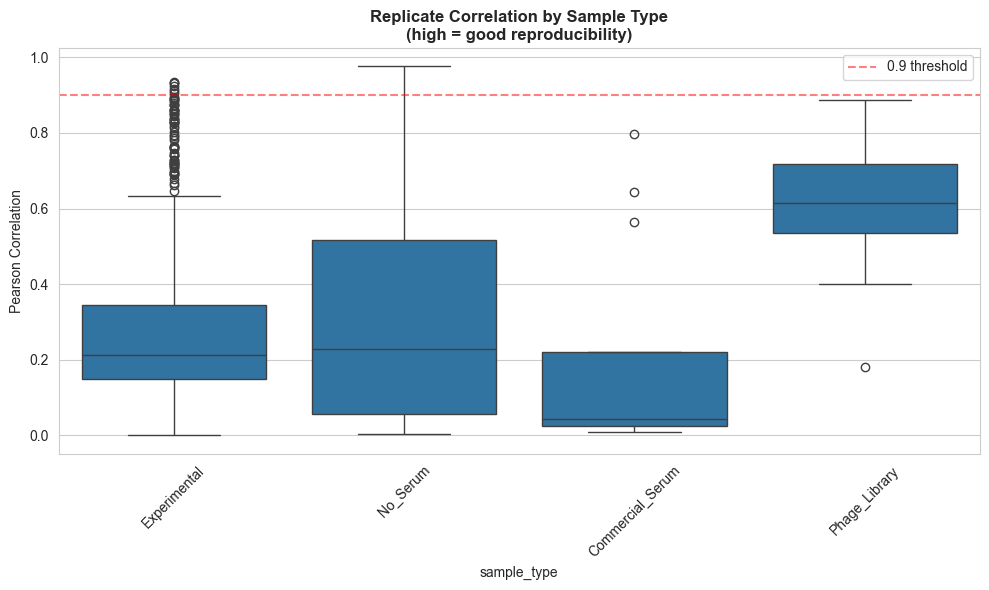


Replicate correlation statistics:
                  count      mean       std       min       25%       50%  \
sample_type                                                                 
Commercial_Serum   12.0  0.199329  0.288578  0.009870  0.025928  0.043621   
Experimental      500.0  0.304342  0.232655  0.000082  0.148425  0.211746   
No_Serum           45.0  0.349046  0.327729  0.002424  0.056412  0.228948   
Phage_Library      12.0  0.612500  0.200197  0.180901  0.534912  0.615283   

                       75%       max  
sample_type                           
Commercial_Serum  0.221636  0.796532  
Experimental      0.344142  0.935524  
No_Serum          0.518103  0.975932  
Phage_Library     0.718355  0.887586  


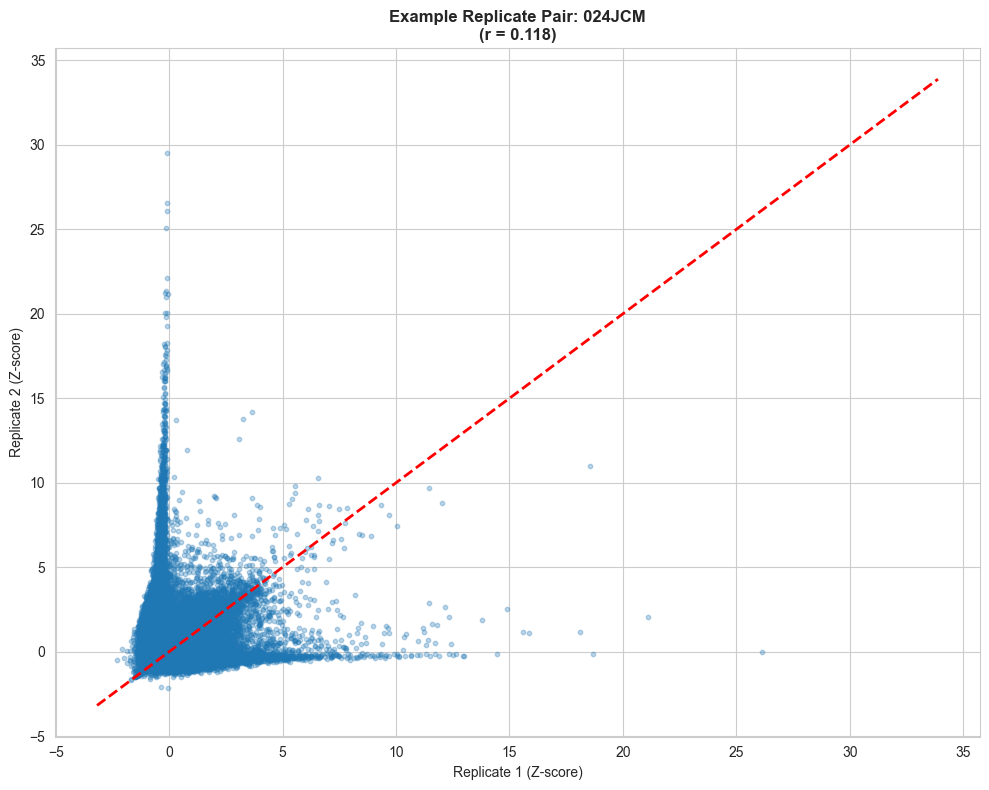

In [42]:
if replicate_cors:
    rep_cor_df = pd.DataFrame(replicate_cors)
    
    # Visualization 26: Replicate correlation by sample type
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rep_cor_df, x='sample_type', y='correlation')
    plt.title('Replicate Correlation by Sample Type\n(high = good reproducibility)', 
              fontsize=12, fontweight='bold')
    plt.ylabel('Pearson Correlation')
    plt.xticks(rotation=45)
    plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='0.9 threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nReplicate correlation statistics:")
    print(rep_cor_df.groupby('sample_type')['correlation'].describe())
    
    # Visualization 27: Example replicate pair
    example_subject = rep_cor_df.iloc[0]['subject']
    example_samples = manifest[manifest['subject'] == example_subject].index.tolist()
    if len(example_samples) == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(data_zscored.loc[example_samples[0]], 
                   data_zscored.loc[example_samples[1]], 
                   alpha=0.3, s=10)
        plt.plot([data_zscored.min().min(), data_zscored.max().max()],
                [data_zscored.min().min(), data_zscored.max().max()],
                'r--', linewidth=2)
        cor_val = np.corrcoef(data_zscored.loc[example_samples[0]], 
                             data_zscored.loc[example_samples[1]])[0, 1]
        plt.title(f'Example Replicate Pair: {example_subject}\n(r = {cor_val:.3f})', 
                 fontsize=12, fontweight='bold')
        plt.xlabel('Replicate 1 (Z-score)')
        plt.ylabel('Replicate 2 (Z-score)')
        plt.tight_layout()
        plt.show()


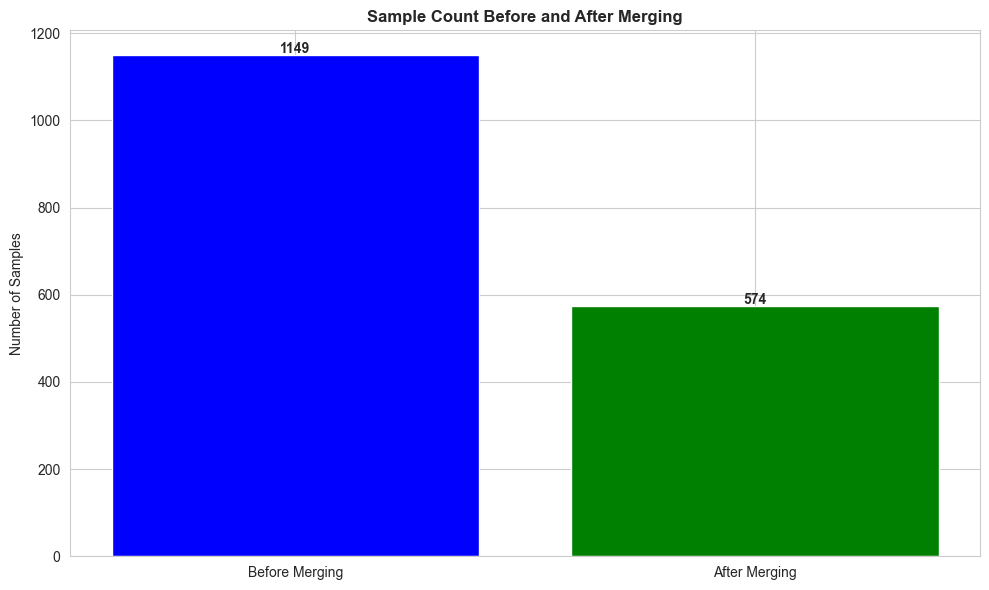

In [43]:
# Visualization 28: Sample count before/after merging
plt.figure(figsize=(10, 6))
count_data = pd.DataFrame({
    'Stage': ['Before Merging', 'After Merging'],
    'Count': [data_zscored.shape[0], data_final.shape[0]]
})
plt.bar(count_data['Stage'], count_data['Count'], color=['blue', 'green'])
plt.title('Sample Count Before and After Merging', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples')
for i, v in enumerate(count_data['Count']):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


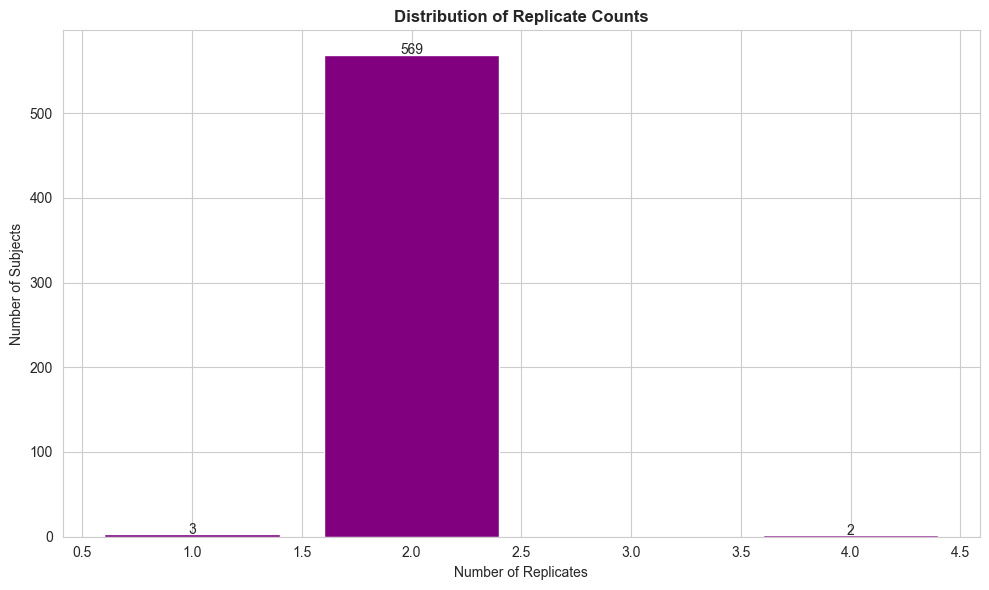

In [44]:
# Visualization 29: Replicate count distribution
plt.figure(figsize=(10, 6))
rep_dist = manifest_final['n_replicates'].value_counts().sort_index()
plt.bar(rep_dist.index, rep_dist.values, color='purple')
plt.title('Distribution of Replicate Counts', fontsize=12, fontweight='bold')
plt.xlabel('Number of Replicates')
plt.ylabel('Number of Subjects')
for i, v in enumerate(rep_dist.values):
    plt.text(rep_dist.index[i], v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.show()


In [45]:
print("\n" + "=" * 80)
print("STEP 11: Final PCA and Quality Assessment")
print("=" * 80)

# Final PCA on merged data
pca_merged = PCA(n_components=10)
pca_result_merged = pca_merged.fit_transform(data_final)
pca_df_merged = pd.DataFrame(pca_result_merged[:, :5], 
                             columns=[f'PC{i+1}' for i in range(5)],
                             index=data_final.index)
pca_df_merged = pd.concat([pca_df_merged, manifest_final], axis=1)

print(f"Explained variance ratio (first 5 PCs): {pca_merged.explained_variance_ratio_[:5]}")
print(f"Cumulative variance explained: {np.cumsum(pca_merged.explained_variance_ratio_[:5])}")



STEP 11: Final PCA and Quality Assessment
Explained variance ratio (first 5 PCs): [0.11777434 0.02258455 0.01758239 0.01287221 0.01258149]
Cumulative variance explained: [0.11777434 0.14035889 0.15794128 0.17081349 0.18339498]


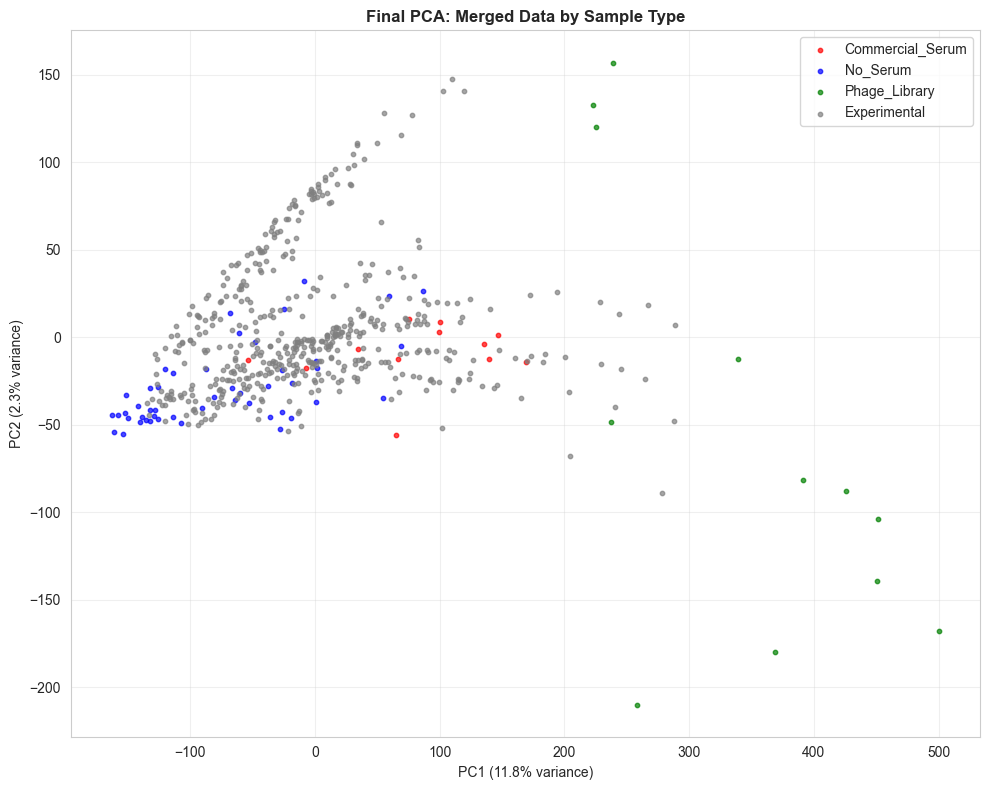

In [46]:
# Visualization 30: Final PCA by sample type
plt.figure(figsize=(10, 8))
for stype, color in sample_type_colors.items():
    mask = pca_df_merged['sample_type'] == stype
    if mask.sum() > 0:
        plt.scatter(pca_df_merged.loc[mask, 'PC1'], pca_df_merged.loc[mask, 'PC2'], 
                   c=color, label=stype, alpha=0.7, s=10)
plt.title('Final PCA: Merged Data by Sample Type', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca_merged.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_merged.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


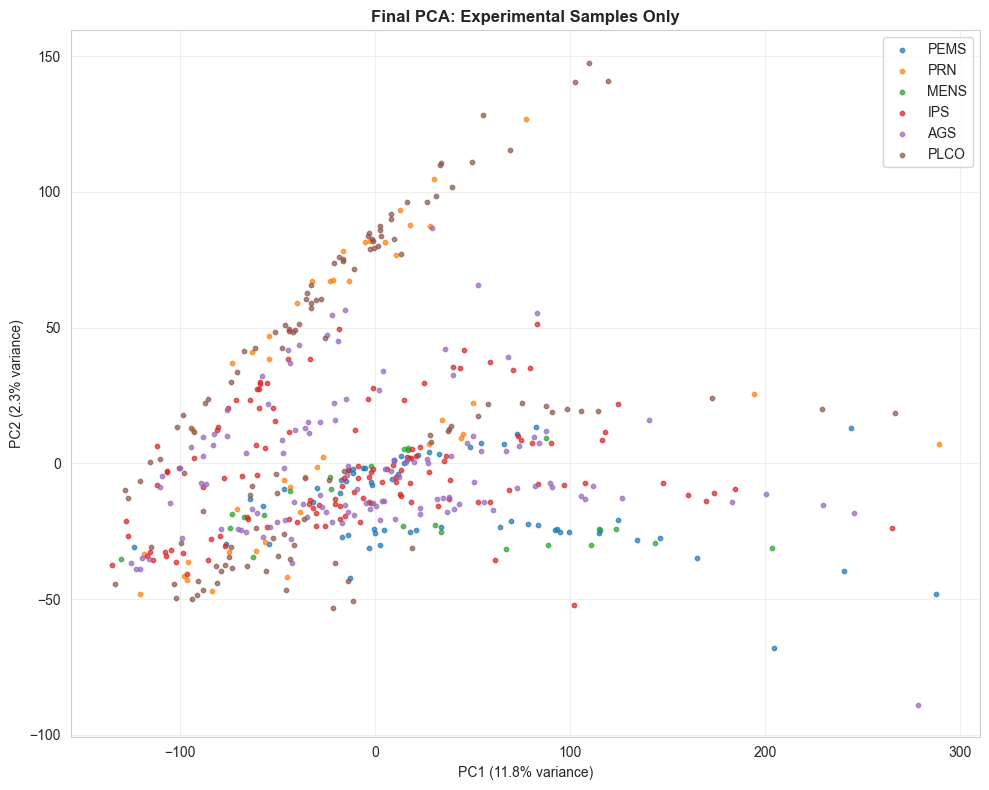

In [47]:
# Visualization 31: Experimental samples only
exp_mask = manifest_final['sample_type'] == 'Experimental'
if exp_mask.sum() > 0:
    plt.figure(figsize=(10, 8))
    exp_pca = pca_df_merged[exp_mask]
    
    # Color by study if available
    if 'study' in exp_pca.columns and exp_pca['study'].nunique() > 1:
        for study in exp_pca['study'].unique():
            study_mask = exp_pca['study'] == study
            plt.scatter(exp_pca.loc[study_mask, 'PC1'], 
                       exp_pca.loc[study_mask, 'PC2'],
                       label=study, alpha=0.7, s=10)
        plt.legend()
    else:
        plt.scatter(exp_pca['PC1'], exp_pca['PC2'], alpha=0.7, s=10)
    
    plt.title('Final PCA: Experimental Samples Only', fontsize=12, fontweight='bold')
    plt.xlabel(f'PC1 ({pca_merged.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca_merged.explained_variance_ratio_[1]:.1%} variance)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


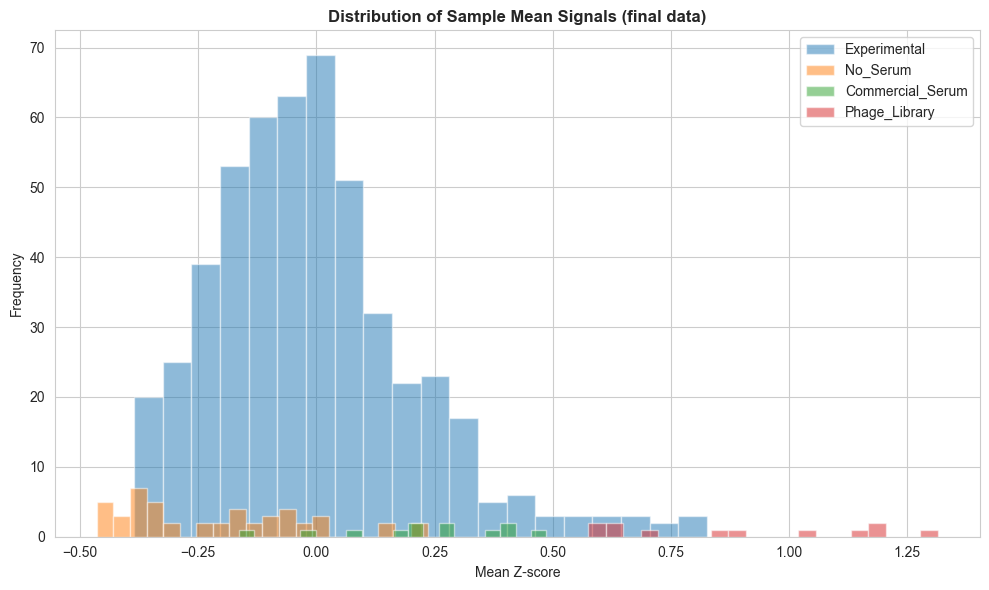

In [48]:
# Visualization 32: Signal distribution by sample type
plt.figure(figsize=(10, 6))
for stype in manifest_final['sample_type'].unique():
    mask = manifest_final['sample_type'] == stype
    sample_means = data_final[mask].mean(axis=1)
    plt.hist(sample_means, alpha=0.5, label=stype, bins=20)
plt.title('Distribution of Sample Mean Signals (final data)', fontsize=12, fontweight='bold')
plt.xlabel('Mean Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


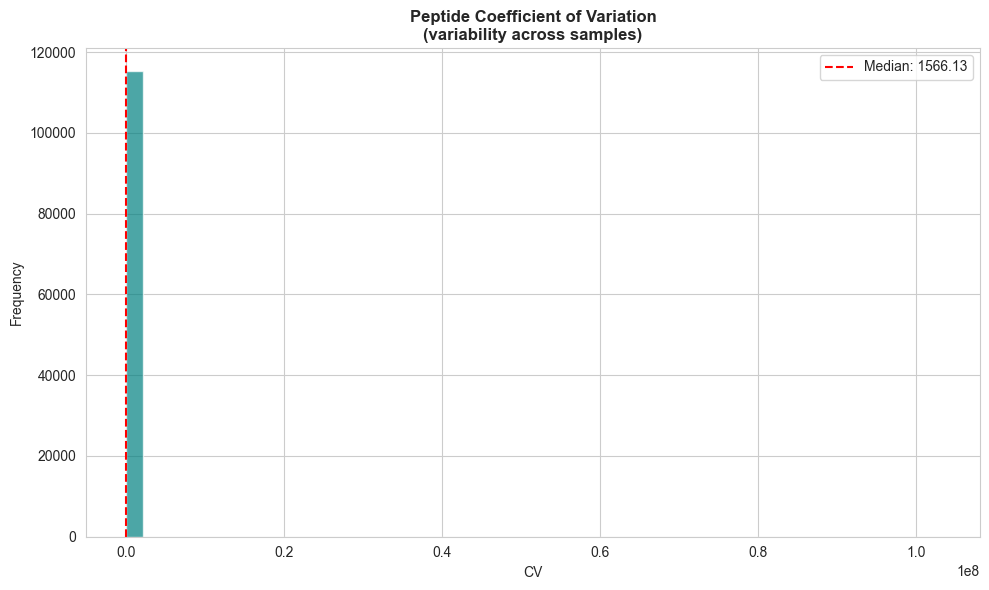

In [49]:
# Calculate peptide coefficient of variation
peptide_cv = data_final.std(axis=0) / (data_final.mean(axis=0).abs() + 1e-10)
peptide_cv = peptide_cv[np.isfinite(peptide_cv)]

# Visualization 33: Peptide CV
plt.figure(figsize=(10, 6))
plt.hist(peptide_cv, bins=50, color='teal', alpha=0.7)
plt.title('Peptide Coefficient of Variation\n(variability across samples)', 
          fontsize=12, fontweight='bold')
plt.xlabel('CV')
plt.ylabel('Frequency')
plt.axvline(x=peptide_cv.median(), color='r', linestyle='--', 
           label=f'Median: {peptide_cv.median():.2f}')
plt.legend()
plt.tight_layout()
plt.show()


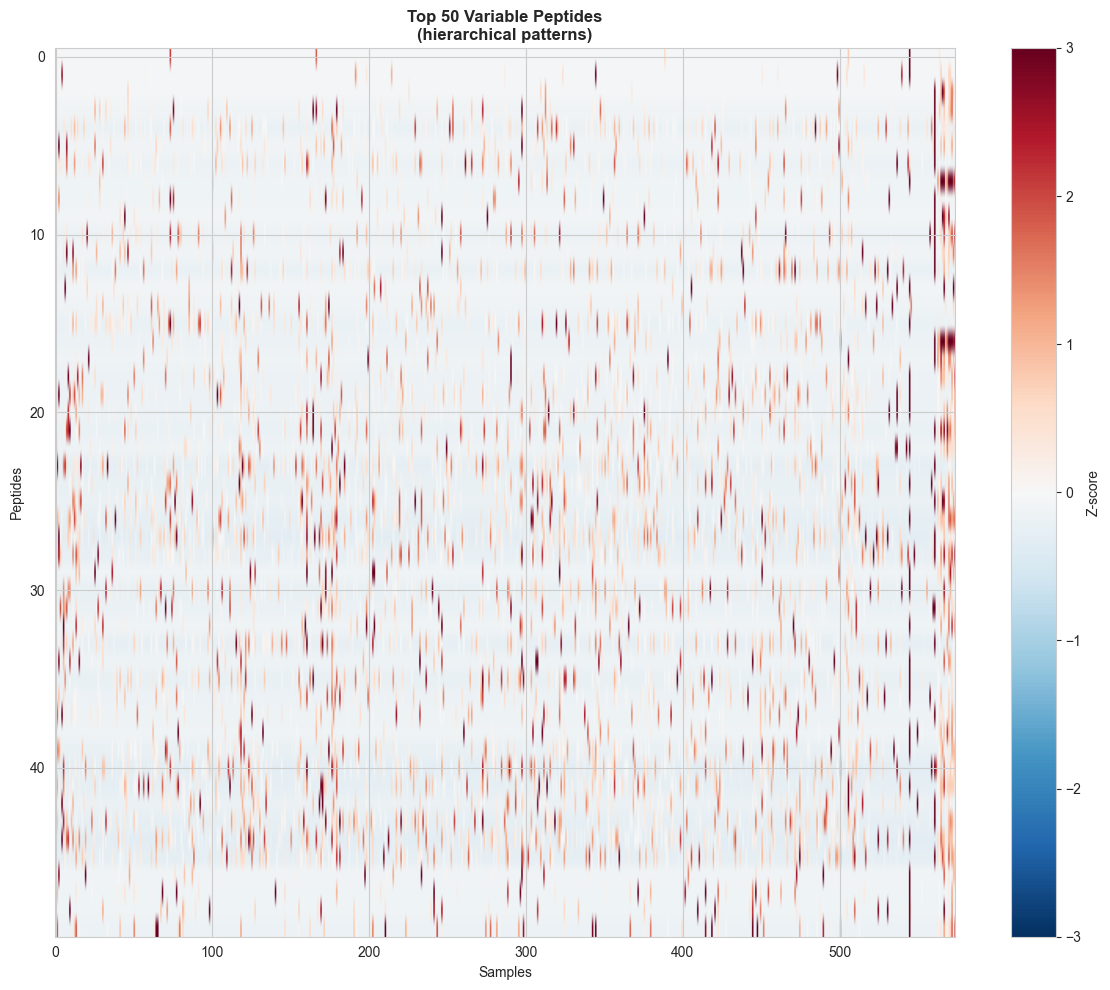

In [50]:
# Visualization 34: Heatmap of top variable peptides
plt.figure(figsize=(12, 10))
top_var_peptides = data_final.var(axis=0).nlargest(50).index
heatmap_data = data_final[top_var_peptides]
# Sort samples by sample type
sorted_idx = manifest_final.sort_values('sample_type').index
heatmap_data_sorted = heatmap_data.loc[sorted_idx]
plt.imshow(heatmap_data_sorted.T, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
plt.title('Top 50 Variable Peptides\n(hierarchical patterns)', fontsize=12, fontweight='bold')
plt.xlabel('Samples')
plt.ylabel('Peptides')
plt.colorbar(label='Z-score')
plt.tight_layout()
plt.show()


In [51]:
# Print summary statistics
print("\n" + "=" * 80)
print("FINAL DATA SUMMARY")
print("=" * 80)
print(f"Total Samples (final): {data_final.shape[0]}")
print(f"Total Peptides: {data_final.shape[1]}")
print(f"Experimental Samples: {(manifest_final['sample_type'] == 'Experimental').sum()}")
print(f"Control Samples: {(manifest_final['sample_type'] != 'Experimental').sum()}")
print(f"Mean Signal Range: {data_final.mean(axis=1).min():.3f} to {data_final.mean(axis=1).max():.3f}")
print(f"Median Peptide CV: {peptide_cv.median():.3f}")
print(f"PC1 Variance Explained: {pca_merged.explained_variance_ratio_[0]:.1%}")



FINAL DATA SUMMARY
Total Samples (final): 574
Total Peptides: 115292
Experimental Samples: 502
Control Samples: 72
Mean Signal Range: -0.465 to 1.316
Median Peptide CV: 1566.130
PC1 Variance Explained: 11.8%


In [52]:
%%time

print("\n" + "=" * 80)
print("STEP 12: Exporting Normalized Data")
print("=" * 80)

# Export the fully normalized and merged data
data_final.to_csv('normalized_data_final.csv')
manifest_final.to_csv('manifest_final.csv')

# Also export intermediate steps for reference
data_plate_corrected.to_csv('normalized_data_plate_corrected.csv')
data_zscored.to_csv('normalized_data_zscored_unmerged.csv')

# Export PCA results
pca_df_merged.to_csv('pca_results_final.csv')

print("\nExported files:")
print("  - normalized_data_final.csv (final merged and normalized data)")
print("  - manifest_final.csv (final sample manifest)")
print("  - normalized_data_plate_corrected.csv (intermediate: plate corrected)")
print("  - normalized_data_zscored_unmerged.csv (intermediate: before merging)")
print("  - pca_results_final.csv (PCA coordinates and metadata)")



STEP 12: Exporting Normalized Data

Exported files:
  - normalized_data_final.csv (final merged and normalized data)
  - manifest_final.csv (final sample manifest)
  - normalized_data_plate_corrected.csv (intermediate: plate corrected)
  - normalized_data_zscored_unmerged.csv (intermediate: before merging)
  - pca_results_final.csv (PCA coordinates and metadata)
CPU times: user 12min 14s, sys: 1min 29s, total: 13min 43s
Wall time: 13min 45s


In [53]:
print("\n" + "=" * 80)
print("NORMALIZATION SUMMARY REPORT")
print("=" * 80)

replicate_correlation_mean = f"{rep_cor_df['correlation'].mean():.3f}" if replicate_cors else 'N/A'

print(f"""
INPUT DATA:
  - Total samples: {data_matrix.shape[0]}
  - Total peptides: {data_matrix.shape[1]}
  - Plates: {manifest['plate'].nunique()}
  - Sample types: {', '.join(manifest['sample_type'].unique())}

NORMALIZATION STEPS PERFORMED:
  1. Background Subtraction: Removed plate-specific non-specific binding
  2. Library Size Normalization: Scaled to median library size
  3. Plate Effect Correction: Used commercial serum controls for correction
  4. Log Transformation: Stabilized variance
  5. Z-score Normalization: Standardized peptide signals
  6. Replicate Merging: Combined technical replicates using median

FINAL OUTPUT:
  - Unique subjects: {data_final.shape[0]}
  - Peptides: {data_final.shape[1]}
  - Experimental samples: {(manifest_final['sample_type'] == 'Experimental').sum()}
  
QUALITY METRICS:
  - Replicate correlation (mean): {replicate_correlation_mean}
  - Peptide CV (median): {peptide_cv.median():.3f}
  - PC1 variance explained: {pca_merged.explained_variance_ratio_[0]:.1%}
  - Data range (Z-scores): {data_final.min().min():.2f} to {data_final.max().max():.2f}

RECOMMENDATIONS FOR DOWNSTREAM ANALYSIS:
  - Use 'normalized_data_final.csv' for all analyses
  - Controls can be filtered out if desired (sample_type != 'Experimental')
  - Data is ready for differential binding analysis, clustering, etc.
  - Consider batch effects if analyzing specific subgroups
""")

print("\n" + "=" * 80)
print("NORMALIZATION COMPLETE!")
print("=" * 80)



NORMALIZATION SUMMARY REPORT

INPUT DATA:
  - Total samples: 1149
  - Total peptides: 115292
  - Plates: 12
  - Sample types: Experimental, No_Serum, Commercial_Serum, Phage_Library

NORMALIZATION STEPS PERFORMED:
  1. Background Subtraction: Removed plate-specific non-specific binding
  2. Library Size Normalization: Scaled to median library size
  3. Plate Effect Correction: Used commercial serum controls for correction
  4. Log Transformation: Stabilized variance
  5. Z-score Normalization: Standardized peptide signals
  6. Replicate Merging: Combined technical replicates using median

FINAL OUTPUT:
  - Unique subjects: 574
  - Peptides: 115292
  - Experimental samples: 502

QUALITY METRICS:
  - Replicate correlation (mean): 0.312
  - Peptide CV (median): 1566.130
  - PC1 variance explained: 11.8%
  - Data range (Z-scores): -3.17 to 33.36

RECOMMENDATIONS FOR DOWNSTREAM ANALYSIS:
  - Use 'normalized_data_final.csv' for all analyses
  - Controls can be filtered out if desired (sampl